## Amazon Food Review - GBDT & RF

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import nltk
import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import cross_validation
from sklearn.preprocessing import normalize
from scipy.sparse import find
from scipy.sparse import csr_matrix
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")

/Users/sriramthotapallim/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
df= pd.read_csv("../../../../Desktop/Prep/ML_Repo/amazon-fine-food-reviews/Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.shape

(568454, 10)

In [7]:
import pickle

def save_data(data,file):
    pickle.dump(data,open(file+".pkl","wb"))
    
def load_data(file):
    data = pickle.load(open(file+".pkl","rb"))
    return data

In [6]:
dt_data = load_data('../Amazon_Food_Review_KNN/150k_nb')
dt_data = dt_data.head(75000)

In [7]:
def confusion_matrix_plot(y_test,pred):
    df_bow = pd.DataFrame(confusion_matrix(y_test, pred))  
    sns.heatmap(df_bow, annot=True)
    tn, fp, fn, tp = confusion_matrix(y_test,pred).ravel()
    print('True Positive',tp)
    print('True Negative',tn)
    print('False Positive',fp)
    print('False Negative',fn)

In [8]:
def metric_scores(y_test,pred):
    acc_scores = [[accuracy_score(y_test, pred)*100,precision_score(y_test,pred),recall_score(y_test,pred),f1_score(y_test,pred)]]
    acc_scores = pd.DataFrame(acc_scores,columns=['Accuracy','Precision score','Recall score','F1 score'])
    return acc_scores

In [1]:
def summary_of_scores_rf():
    x = PrettyTable()
    x.field_names = ["Model", "CV - Type", "Best No. of Base Learners","Best Accuracy"]
    x.add_row(["BOW","Grid Search",load_data('bow_grid_search_rf').best_params_.get('n_estimators'),load_data('bow_grid_search_rf').best_score_*100])
    x.add_row(["Trigram","Grid Search", load_data('trigram_grid_search_rf').best_params_.get('n_estimators'),load_data('trigram_grid_search_rf').best_score_*100])
    x.add_row(["Tf-Idf","Grid Search", load_data('tfidf_grid_search_rf').best_params_.get('n_estimators'),load_data('tfidf_grid_search_rf').best_score_*100])
    x.add_row(["W2V","Grid Search", load_data('w2v_grid_search_rf').best_params_.get('n_estimators'),load_data('w2v_grid_search_rf').best_score_*100])
    x.add_row(["Tf-Idf - W2v","Grid Search", load_data('tfidf_w2v_grid_search_rf').best_params_.get('n_estimators'),load_data('tfidf_w2v_grid_search_rf').best_score_*100])
    print(x)

In [10]:
def summary_of_scores_gbdt():
    x = PrettyTable()
    x.field_names = ["Model", "CV - Type", "Best No. of Base Learners","Max. Depth","Learning Rate","Best Accuracy"]
    x.add_row(["BOW","Grid Search",load_data('bow_grid_search_gbdt').best_params_.get('n_estimators'),load_data('bow_grid_search_gbdt').best_params_.get('max_depth'),load_data('bow_grid_search_gbdt').best_params_.get('learning_rate'),load_data('bow_grid_search_gbdt').best_score_*100])
    x.add_row(["Trigram","Grid Search", load_data('trigram_grid_search_gbdt').best_params_.get('n_estimators'),load_data('trigram_grid_search_gbdt').best_params_.get('max_depth'),load_data('trigram_grid_search_gbdt').best_params_.get('learning_rate'),load_data('trigram_grid_search_gbdt').best_score_*100])
    x.add_row(["Tf-Idf","Grid Search", load_data('tfidf_grid_search_gbdt').best_params_.get('n_estimators'),load_data('tfidf_grid_search_gbdt').best_params_.get('max_depth'),load_data('tfidf_grid_search_gbdt').best_params_.get('learning_rate'),load_data('tfidf_grid_search_gbdt').best_score_*100])
    x.add_row(["W2V","Grid Search", load_data('w2v_grid_search_gbdt').best_params_.get('n_estimators'),load_data('w2v_grid_search_gbdt').best_params_.get('max_depth'),load_data('w2v_grid_search_gbdt').best_params_.get('learning_rate'),load_data('w2v_grid_search_gbdt').best_score_*100])
    x.add_row(["Tf-Idf - W2v","Grid Search", load_data('tfidf_w2v_grid_search_gbdt').best_params_.get('n_estimators'),load_data('tfidf_w2v_grid_search_gbdt').best_params_.get('max_depth'),load_data('tfidf_w2v_grid_search_gbdt').best_params_.get('learning_rate'),load_data('tfidf_w2v_grid_search_gbdt').best_score_*100])
    print(x)

In [27]:
def acc_vs_base_learners_plot(base_learners,acc_scores):
    sns.set_style("whitegrid")
    plt.plot(base_learners,acc_scores)
    plt.xlabel("No. of Base Learners")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Base Learners")
    plt.show()

### Bag Of Words 

### Random Forest

### Best Hyperparameter No. of Base Learners using GridSearchCV

In [10]:
x_train, x_test, y_train, y_test = train_test_split(dt_data['Cleaned_Text'] ,dt_data['Score'], test_size=0.3, shuffle = False)
x_test.head()

347196    top favorit popcorn season time purchas area n...
87753     genuin high fructos corn syrup one buy heinz k...
74084     seem prefer nice juici meal fussi eater sweet ...
118859    love use pomona pectin allow use less sugar re...
37155     use season mixtur brown sugar chipotl chili po...
Name: Cleaned_Text, dtype: object

In [11]:
from sklearn.preprocessing import Normalizer
count_vect = CountVectorizer()
x_train = count_vect.fit_transform(x_train)
normal_scale = Normalizer().fit(x_train)
x_train = normal_scale.transform(x_train)
x_test = count_vect.transform(x_test)
x_test = normal_scale.transform(x_test)

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [20]:
rf = RandomForestClassifier()
time_split_cv = TimeSeriesSplit(n_splits = 5)
#max_depth_list = sorted(np.random.randint(1,150,15))
base_learners = [i*10 for i in range(1,11)]
param_grid = {'n_estimators':base_learners}
grid_search = GridSearchCV(rf,param_grid,cv=time_split_cv,verbose=1,n_jobs= -1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.7min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [21]:
save_data(grid_search,'bow_grid_search_rf')

In [22]:
a1 = load_data('bow_grid_search_rf')

In [23]:
print('Best No. of Base Learners ',a1.best_params_['n_estimators'])
print('Best Accuracy %f% %'%(a1.best_score_*100))

Best No. of Base Learners  20
Best Accuracy 89.842286%


In [24]:
from sklearn.metrics import accuracy_score
rf_optimal = RandomForestClassifier(n_estimators = a1.best_params_['n_estimators'])
rf_optimal.fit(x_train, y_train)
pred = rf_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [25]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,88.608889,0.88638,0.996832,0.938367


True Positive 19511
True Negative 426
False Positive 2501
False Negative 62


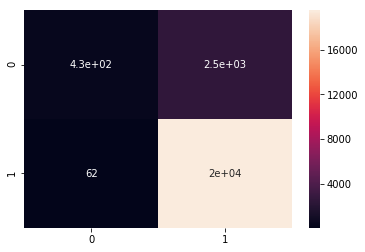

In [26]:
confusion_matrix_plot(y_test,pred)

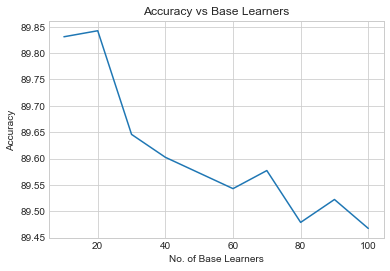

In [28]:
acc_vs_base_learners_plot(base_learners,a1.cv_results_['mean_test_score']*100)

### Gradient Boosted Decision Tree

In [29]:
from xgboost import XGBClassifier

In [32]:
gbdt = XGBClassifier()
time_split_cv = TimeSeriesSplit(n_splits = 3)
max_depth_list = sorted(np.random.randint(1,20,5))
base_learners = [i*10 for i in range(1,11)]
learning_rate_param = [i/10 for i in range(1,8)]
param_grid = {'n_estimators':base_learners,'max_depth':max_depth_list,'learning_rate':learning_rate_param}
grid_search = GridSearchCV(gbdt,param_grid,cv=time_split_cv,verbose=1,n_jobs= -1)
grid_search.fit(x_train,y_train)

Fitting 3 folds for each of 350 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 52.5min
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed: 71.9min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_depth': [4, 5, 9, 10, 18], 'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [33]:
save_data(grid_search,'bow_grid_search_gbdt')

In [34]:
a1 = load_data('bow_grid_search_gbdt')

In [39]:
print('Best No. of Base Learners is %d, Max. Depth is %d and Learning Rate is %0.2f'%(a1.best_params_['n_estimators'],a1.best_params_['max_depth'],a1.best_params_['learning_rate']))
print('Best Accuracy %f% %'%(a1.best_score_*100))

Best No. of Base Learners is 100, Max. Depth is 18 and Learning Rate is 0.50
Best Accuracy 91.751111%


In [41]:
from sklearn.metrics import accuracy_score
gbdt_optimal = XGBClassifier(n_estimators = a1.best_params_['n_estimators'],max_depth =a1.best_params_['max_depth'],learning_rate = a1.best_params_['learning_rate'])
gbdt_optimal.fit(x_train, y_train)
pred = gbdt_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [42]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,91.146667,0.922356,0.98079,0.950676


True Positive 19197
True Negative 1311
False Positive 1616
False Negative 376


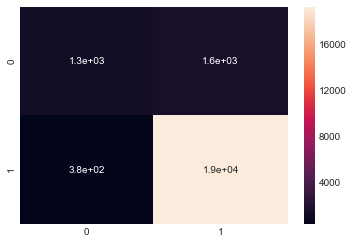

In [43]:
confusion_matrix_plot(y_test,pred)

### Trigram - Decision Trees

### Random Forest

### Best Hyperparameter No. of Base Learners using GridSearchCV

In [63]:
x_train, x_test, y_train, y_test = train_test_split(dt_data['Cleaned_Text'] ,dt_data['Score'], test_size=0.3, shuffle = False)
x_test.head()

347196    top favorit popcorn season time purchas area n...
87753     genuin high fructos corn syrup one buy heinz k...
74084     seem prefer nice juici meal fussi eater sweet ...
118859    love use pomona pectin allow use less sugar re...
37155     use season mixtur brown sugar chipotl chili po...
Name: Cleaned_Text, dtype: object

In [64]:
ngram_vect = CountVectorizer(ngram_range=(1,3))
x_train = ngram_vect.fit_transform(x_train)
normal_scale = Normalizer().fit(x_train)
x_train = normal_scale.transform(x_train)
x_test = ngram_vect.transform(x_test)
x_test = normal_scale.transform(x_test)

In [68]:
rf = RandomForestClassifier()
time_split_cv = TimeSeriesSplit(n_splits = 3)
base_learners = [i*10 for i in range(1,11)]
param_grid = {'n_estimators':base_learners}
grid_search = GridSearchCV(rf,param_grid,cv=time_split_cv,verbose=50,n_jobs= -1)
grid_search.fit(x_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=10 .................................................
[CV] n_estimators=10 .................................................
[CV] n_estimators=10 .................................................
[CV] n_estimators=20 .................................................
[CV] n_estimators=20 .................................................
[CV] n_estimators=20 .................................................
[CV] n_estimators=30 .................................................
[CV] n_estimators=30 .................................................
[CV] ......... n_estimators=10, score=0.893104761904762, total= 1.3min
[CV] n_estimators=30 .................................................
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.3min
[CV] ......... n_estimators=20, score=0.891352380952381, total= 2.5min
[CV] n_estimators=40 .................................................
[Parallel(n_jobs=-1)]: Do

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=50)

In [69]:
save_data(grid_search,'trigram_grid_search_rf')

In [70]:
a1 = load_data('trigram_grid_search_rf')

In [72]:
print('Best No. of Base Learners ',a1.best_params_['n_estimators'])
print('Best Accuracy %f% %'%(a1.best_score_*100))

Best No. of Base Learners  10
Best Accuracy 89.183492%


In [73]:
from sklearn.metrics import accuracy_score
rf_optimal = RandomForestClassifier(n_estimators = a1.best_params_['n_estimators'])
rf_optimal.fit(x_train, y_train)
pred = rf_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [74]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,88.435556,0.884952,0.996628,0.937476


True Positive 19507
True Negative 391
False Positive 2536
False Negative 66


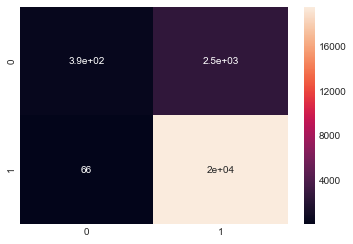

In [75]:
confusion_matrix_plot(y_test,pred)

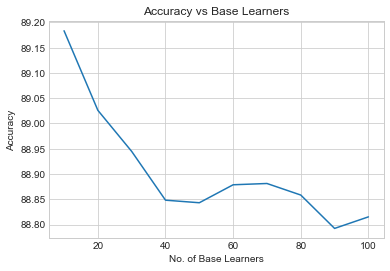

In [76]:
acc_vs_base_learners_plot(base_learners,a1.cv_results_['mean_test_score']*100)

### Gradient Boosted Decision Tree

In [77]:
gbdt = XGBClassifier()
time_split_cv = TimeSeriesSplit(n_splits = 3)
max_depth_list = sorted(np.random.randint(1,10,3))
base_learners = [i*10 for i in range(1,8)]
learning_rate_param = [i/10 for i in range(1,8)]
param_grid = {'n_estimators':base_learners,'max_depth':max_depth_list,'learning_rate':learning_rate_param}
grid_search = GridSearchCV(gbdt,param_grid,cv=time_split_cv,verbose=50,n_jobs= -1)
grid_search.fit(x_train,y_train)

Fitting 3 folds for each of 147 candidates, totalling 441 fits
[CV] learning_rate=0.1, max_depth=1, n_estimators=10 .................
[CV] learning_rate=0.1, max_depth=1, n_estimators=10 .................
[CV] learning_rate=0.1, max_depth=1, n_estimators=10 .................
[CV] learning_rate=0.1, max_depth=1, n_estimators=20 .................
[CV] learning_rate=0.1, max_depth=1, n_estimators=20 .................
[CV] learning_rate=0.1, max_depth=1, n_estimators=20 .................
[CV] learning_rate=0.1, max_depth=1, n_estimators=30 .................
[CV] learning_rate=0.1, max_depth=1, n_estimators=30 .................
[CV]  learning_rate=0.1, max_depth=1, n_estimators=10, score=0.8893714285714286, total=   8.5s
[CV] learning_rate=0.1, max_depth=1, n_estimators=30 .................
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.8s
[CV]  learning_rate=0.1, max_depth=1, n_estimators=20, score=0.8892190476190476, total=  12.0s
[CV] learning_rate=0.1, max_depth=1, n_estimat

[CV] learning_rate=0.1, max_depth=1, n_estimators=70 .................
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[CV]  learning_rate=0.1, max_depth=1, n_estimators=40, score=0.8797714285714285, total=  42.1s
[CV] learning_rate=0.1, max_depth=4, n_estimators=10 .................
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:  2.4min
[CV]  learning_rate=0.1, max_depth=1, n_estimators=50, score=0.8902095238095238, total=  35.2s
[CV] learning_rate=0.1, max_depth=4, n_estimators=10 .................
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:  2.5min
[CV]  learning_rate=0.1, max_depth=1, n_estimators=70, score=0.8903619047619048, total=  26.8s
[CV] learning_rate=0.1, max_depth=4, n_estimators=10 .................
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.7min
[CV]  learning_rate=0.1, max_depth=4, n_estimators=10, score=0.8919619047619047, total=  14.5s
[CV] learning_rate=0.1, max_depth=4, n_estimators=20 .................
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:  6.9min
[CV]  learning_rate=0.2, max_depth=1, n_estimators=40, score=0.8928761904761905, total=  29.3s
[CV] learning_rate=0.2, max_depth=1, n_estimators=60 .................
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:  7.0min
[CV]  learning_rate=0.2, max_depth=1, n_estimators=50, score=0.8927238095238095, total=  20.7s
[CV] learning_rate=0.2, max_depth=1, n_estimators=60 .................
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:  7.0min
[CV]  learning_rate=0.1, max_depth=4, n_estimators=70, score=0.9029333333333334, total= 2.3min
[CV] learning_rate=0.2, max_depth=1, n_estimators=60 .................
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:  7.2min
[CV]  learning_rate=0.2, max_depth=1, n_estimators=50, score=0.8939428571428572, total=  35.1s
[CV] learning_rate=0.2, max_depth=1, n_estimators=70 .................
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  7.3min
[CV]  learning_rate=0.2, m

[Parallel(n_jobs=-1)]: Done 106 tasks      | elapsed:  9.9min
[CV]  learning_rate=0.2, max_depth=1, n_estimators=60, score=0.8857142857142857, total= 1.0min
[CV] learning_rate=0.2, max_depth=4, n_estimators=40 .................
[Parallel(n_jobs=-1)]: Done 107 tasks      | elapsed:  9.9min
[CV]  learning_rate=0.2, max_depth=4, n_estimators=10, score=0.8849523809523809, total=  37.4s
[CV] learning_rate=0.2, max_depth=4, n_estimators=40 .................
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed: 10.0min
[CV]  learning_rate=0.2, max_depth=4, n_estimators=30, score=0.8995809523809524, total=  35.9s
[CV] learning_rate=0.2, max_depth=4, n_estimators=40 .................
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 10.3min
[CV]  learning_rate=0.2, max_depth=4, n_estimators=20, score=0.8969904761904762, total=  45.5s
[CV] learning_rate=0.2, max_depth=4, n_estimators=50 .................
[Parallel(n_jobs=-1)]: Done 110 tasks      | elapsed: 10.3min
[CV]  learning_rate=0.2, m

[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed: 14.6min
[CV]  learning_rate=0.3, max_depth=1, n_estimators=50, score=0.8898285714285714, total=  52.4s
[CV] learning_rate=0.3, max_depth=1, n_estimators=20 .................
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed: 14.7min
[CV]  learning_rate=0.3, max_depth=1, n_estimators=10, score=0.8904380952380953, total=   8.3s
[CV] learning_rate=0.3, max_depth=1, n_estimators=20 .................
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed: 14.7min
[CV]  learning_rate=0.3, max_depth=1, n_estimators=10, score=0.8902095238095238, total=  12.2s
[CV] learning_rate=0.3, max_depth=1, n_estimators=20 .................
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed: 14.9min
[CV]  learning_rate=0.3, max_depth=1, n_estimators=20, score=0.8924190476190477, total=  11.4s
[CV] learning_rate=0.3, max_depth=1, n_estimators=30 .................
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 14.9min
[CV]  learning_rate=0.3, m

[CV]  learning_rate=0.3, max_depth=4, n_estimators=40, score=0.9110857142857143, total= 1.4min
[CV] learning_rate=0.3, max_depth=4, n_estimators=70 .................
[Parallel(n_jobs=-1)]: Done 179 tasks      | elapsed: 18.3min
[CV]  learning_rate=0.3, max_depth=4, n_estimators=30, score=0.8982095238095238, total= 1.6min
[CV] learning_rate=0.3, max_depth=4, n_estimators=70 .................
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed: 18.4min
[CV]  learning_rate=0.3, max_depth=4, n_estimators=60, score=0.9128380952380952, total= 1.1min
[CV] learning_rate=0.3, max_depth=4, n_estimators=70 .................
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed: 18.7min
[CV]  learning_rate=0.3, max_depth=4, n_estimators=50, score=0.9126857142857143, total= 1.7min
[CV] learning_rate=0.4, max_depth=1, n_estimators=10 .................
[Parallel(n_jobs=-1)]: Done 182 tasks      | elapsed: 18.9min
[CV]  learning_rate=0.4, max_depth=1, n_estimators=10, score=0.8918095238095238, total= 

[CV]  learning_rate=0.4, max_depth=1, n_estimators=20, score=0.886095238095238, total=  26.0s
[CV] learning_rate=0.4, max_depth=1, n_estimators=50 .................
[Parallel(n_jobs=-1)]: Done 215 tasks      | elapsed: 22.1min
[CV]  learning_rate=0.4, max_depth=1, n_estimators=40, score=0.8992761904761905, total=  18.7s
[CV] learning_rate=0.4, max_depth=1, n_estimators=50 .................
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed: 22.1min
[CV]  learning_rate=0.4, max_depth=1, n_estimators=30, score=0.8978285714285714, total=  24.9s
[CV] learning_rate=0.4, max_depth=1, n_estimators=50 .................
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 22.2min
[CV]  learning_rate=0.4, max_depth=1, n_estimators=70, score=0.8966857142857143, total= 1.2min
[CV] learning_rate=0.4, max_depth=1, n_estimators=60 .................
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed: 22.3min
[CV]  learning_rate=0.3, max_depth=4, n_estimators=70, score=0.9072, total= 3.6min
[CV] l

[CV] learning_rate=0.5, max_depth=1, n_estimators=30 .................
[Parallel(n_jobs=-1)]: Done 251 tasks      | elapsed: 26.3min
[CV]  learning_rate=0.4, max_depth=4, n_estimators=60, score=0.9158095238095239, total= 2.0min
[CV] learning_rate=0.5, max_depth=1, n_estimators=30 .................
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed: 26.6min
[CV]  learning_rate=0.5, max_depth=1, n_estimators=30, score=0.9011047619047619, total=  14.5s
[CV] learning_rate=0.5, max_depth=1, n_estimators=30 .................
[Parallel(n_jobs=-1)]: Done 253 tasks      | elapsed: 26.6min
[CV]  learning_rate=0.5, max_depth=1, n_estimators=20, score=0.8991238095238095, total=  18.0s
[CV] learning_rate=0.5, max_depth=1, n_estimators=40 .................
[Parallel(n_jobs=-1)]: Done 254 tasks      | elapsed: 26.7min
[CV]  learning_rate=0.5, max_depth=1, n_estimators=20, score=0.8883809523809524, total=  24.8s
[CV] learning_rate=0.5, max_depth=1, n_estimators=40 .................
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Done 287 tasks      | elapsed: 29.6min
[CV]  learning_rate=0.5, max_depth=1, n_estimators=50, score=0.9063619047619048, total=  40.3s
[CV] learning_rate=0.5, max_depth=4, n_estimators=10 .................
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed: 29.6min
[CV]  learning_rate=0.5, max_depth=1, n_estimators=70, score=0.9081142857142858, total=  29.9s
[CV] learning_rate=0.5, max_depth=4, n_estimators=10 .................
[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed: 29.8min
[CV]  learning_rate=0.5, max_depth=4, n_estimators=10, score=0.8997333333333334, total=  15.6s
[CV] learning_rate=0.5, max_depth=4, n_estimators=20 .................
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed: 29.9min
[CV]  learning_rate=0.5, max_depth=1, n_estimators=60, score=0.9083428571428571, total=  45.5s
[CV] learning_rate=0.5, max_depth=4, n_estimators=20 .................
[Parallel(n_jobs=-1)]: Done 291 tasks      | elapsed: 29.9min
[CV]  learning_rate=0.5, m

[CV]  learning_rate=0.6, max_depth=1, n_estimators=50, score=0.9085714285714286, total=  21.4s
[CV] learning_rate=0.6, max_depth=1, n_estimators=60 .................
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed: 34.4min
[CV]  learning_rate=0.5, max_depth=4, n_estimators=70, score=0.9186285714285715, total= 2.4min
[CV] learning_rate=0.6, max_depth=1, n_estimators=60 .................
[Parallel(n_jobs=-1)]: Done 325 tasks      | elapsed: 34.5min
[CV]  learning_rate=0.6, max_depth=1, n_estimators=50, score=0.9079619047619047, total=  35.9s
[CV] learning_rate=0.6, max_depth=1, n_estimators=70 .................
[Parallel(n_jobs=-1)]: Done 326 tasks      | elapsed: 34.7min
[CV]  learning_rate=0.6, max_depth=1, n_estimators=40, score=0.8984380952380953, total=  43.0s
[CV] learning_rate=0.6, max_depth=1, n_estimators=70 .................
[Parallel(n_jobs=-1)]: Done 327 tasks      | elapsed: 34.7min
[CV]  learning_rate=0.6, max_depth=1, n_estimators=60, score=0.9094095238095238, total= 

[CV]  learning_rate=0.6, max_depth=4, n_estimators=10, score=0.8983619047619048, total=  37.3s
[CV] learning_rate=0.6, max_depth=4, n_estimators=40 .................
[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed: 37.5min
[CV]  learning_rate=0.6, max_depth=4, n_estimators=20, score=0.9099428571428572, total=  44.3s
[CV] learning_rate=0.6, max_depth=4, n_estimators=40 .................
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 37.7min
[CV]  learning_rate=0.6, max_depth=4, n_estimators=30, score=0.9112380952380953, total=  34.6s
[CV] learning_rate=0.6, max_depth=4, n_estimators=50 .................
[Parallel(n_jobs=-1)]: Done 362 tasks      | elapsed: 37.8min
[CV]  learning_rate=0.6, max_depth=1, n_estimators=70, score=0.9024761904761904, total= 1.2min
[CV] learning_rate=0.6, max_depth=4, n_estimators=50 .................
[Parallel(n_jobs=-1)]: Done 363 tasks      | elapsed: 37.8min
[CV]  learning_rate=0.6, max_depth=4, n_estimators=40, score=0.9142095238095238, total= 

[CV]  learning_rate=0.7, max_depth=1, n_estimators=50, score=0.9003428571428571, total=  51.4s
[CV] learning_rate=0.7, max_depth=1, n_estimators=20 .................
[Parallel(n_jobs=-1)]: Done 396 tasks      | elapsed: 42.1min
[CV]  learning_rate=0.7, max_depth=1, n_estimators=10, score=0.8972952380952381, total=  11.9s
[CV] learning_rate=0.7, max_depth=1, n_estimators=20 .................
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed: 42.3min
[CV]  learning_rate=0.7, max_depth=1, n_estimators=20, score=0.8998857142857143, total=  11.3s
[CV] learning_rate=0.7, max_depth=1, n_estimators=30 .................
[Parallel(n_jobs=-1)]: Done 398 tasks      | elapsed: 42.3min
[CV]  learning_rate=0.7, max_depth=1, n_estimators=10, score=0.8870857142857143, total=  15.6s
[CV] learning_rate=0.7, max_depth=1, n_estimators=30 .................
[Parallel(n_jobs=-1)]: Done 399 tasks      | elapsed: 42.4min
[CV]  learning_rate=0.7, max_depth=1, n_estimators=70, score=0.9117714285714286, total= 

[CV]  learning_rate=0.7, max_depth=4, n_estimators=50, score=0.9153523809523809, total= 1.8min
[CV]  learning_rate=0.7, max_depth=4, n_estimators=40, score=0.9091047619047619, total= 2.1min
[Parallel(n_jobs=-1)]: Done 435 out of 441 | elapsed: 46.7min remaining:   38.6s
[CV]  learning_rate=0.7, max_depth=4, n_estimators=70, score=0.9157333333333333, total= 1.2min
[CV]  learning_rate=0.7, max_depth=4, n_estimators=60, score=0.9161904761904762, total= 2.1min
[CV]  learning_rate=0.7, max_depth=4, n_estimators=50, score=0.9113904761904762, total= 2.6min
[CV]  learning_rate=0.7, max_depth=4, n_estimators=70, score=0.9180952380952381, total= 2.1min
[CV]  learning_rate=0.7, max_depth=4, n_estimators=60, score=0.9124571428571429, total= 2.8min
[CV]  learning_rate=0.7, max_depth=4, n_estimators=70, score=0.9135238095238095, total= 3.0min
[Parallel(n_jobs=-1)]: Done 441 out of 441 | elapsed: 49.1min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70], 'max_depth': [1, 1, 4], 'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=50)

In [78]:
save_data(grid_search,'trigram_grid_search_gbdt')

In [79]:
a1 = load_data('trigram_grid_search_gbdt')

In [80]:
print('Best No. of Base Learners is %d, Max. Depth is %d and Learning Rate is %0.2f'%(a1.best_params_['n_estimators'],a1.best_params_['max_depth'],a1.best_params_['learning_rate']))
print('Best Accuracy %f% %'%(a1.best_score_*100))

Best No. of Base Learners is 70, Max. Depth is 4 and Learning Rate is 0.70
Best Accuracy 91.578413%


In [81]:
from sklearn.metrics import accuracy_score
gbdt_optimal = XGBClassifier(n_estimators = a1.best_params_['n_estimators'],max_depth =a1.best_params_['max_depth'],learning_rate = a1.best_params_['learning_rate'])
gbdt_optimal.fit(x_train, y_train)
pred = gbdt_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [82]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,91.084444,0.92861,0.972258,0.949933


True Positive 19030
True Negative 1464
False Positive 1463
False Negative 543


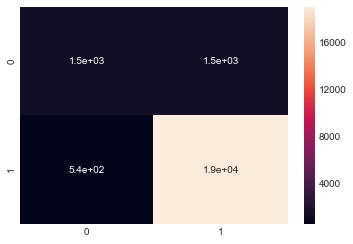

In [83]:
confusion_matrix_plot(y_test,pred)

### Tf-Idf 

### Random Forest

### Best Hyperparameter No. of Base Learners using GridSearchCV

In [84]:
x_train, x_test, y_train, y_test = train_test_split(dt_data['Cleaned_Text'] ,dt_data['Score'], test_size=0.3, shuffle = False)
x_test.head()

347196    top favorit popcorn season time purchas area n...
87753     genuin high fructos corn syrup one buy heinz k...
74084     seem prefer nice juici meal fussi eater sweet ...
118859    love use pomona pectin allow use less sugar re...
37155     use season mixtur brown sugar chipotl chili po...
Name: Cleaned_Text, dtype: object

In [85]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_train = tf_idf_vect.fit_transform(x_train)
normal_scale = Normalizer().fit(x_train)
x_train = normal_scale.transform(x_train)
x_test = tf_idf_vect.transform(x_test)
x_test = normal_scale.transform(x_test)

In [86]:
rf = RandomForestClassifier()
time_split_cv = TimeSeriesSplit(n_splits = 3)
base_learners = [i*10 for i in range(1,11)]
param_grid = {'n_estimators':base_learners}
grid_search = GridSearchCV(rf,param_grid,cv=time_split_cv,verbose=50,n_jobs= -1)
grid_search.fit(x_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=10 .................................................
[CV] n_estimators=10 .................................................
[CV] n_estimators=10 .................................................
[CV] n_estimators=20 .................................................
[CV] n_estimators=20 .................................................
[CV] n_estimators=20 .................................................
[CV] n_estimators=30 .................................................
[CV] n_estimators=30 .................................................
[CV] ........ n_estimators=10, score=0.8947809523809523, total=  32.6s
[CV] n_estimators=30 .................................................
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   33.4s
[CV] ......... n_estimators=20, score=0.893104761904762, total= 1.2min
[CV] n_estimators=40 .................................................
[Parallel(n_jobs=-1)]: Do

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=50)

In [87]:
save_data(grid_search,'tfidf_grid_search_rf')

In [88]:
a1 = load_data('tfidf_grid_search_rf')

In [89]:
print('Best No. of Base Learners ',a1.best_params_['n_estimators'])
print('Best Accuracy %f% %'%(a1.best_score_*100))

Best No. of Base Learners  10
Best Accuracy 89.485714%


In [90]:
from sklearn.metrics import accuracy_score
rf_optimal = RandomForestClassifier(n_estimators = a1.best_params_['n_estimators'])
rf_optimal.fit(x_train, y_train)
pred = rf_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [91]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,88.36,0.885248,0.995197,0.937008


True Positive 19479
True Negative 402
False Positive 2525
False Negative 94


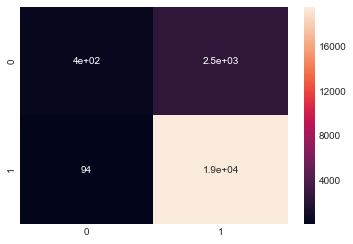

In [92]:
confusion_matrix_plot(y_test,pred)

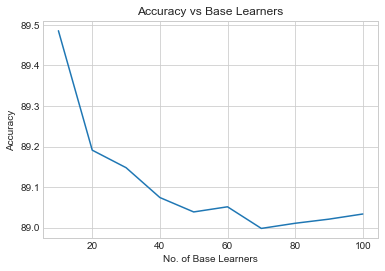

In [93]:
acc_vs_base_learners_plot(base_learners,a1.cv_results_['mean_test_score']*100)

### Gradient Boosted Decision Tree

In [94]:
gbdt = XGBClassifier()
time_split_cv = TimeSeriesSplit(n_splits = 3)
max_depth_list = sorted(np.random.randint(1,10,3))
base_learners = [i*10 for i in range(1,8)]
learning_rate_param = [i/10 for i in range(1,8)]
param_grid = {'n_estimators':base_learners,'max_depth':max_depth_list,'learning_rate':learning_rate_param}
grid_search = GridSearchCV(gbdt,param_grid,cv=time_split_cv,verbose=50,n_jobs= -1)
grid_search.fit(x_train,y_train)

Fitting 3 folds for each of 147 candidates, totalling 441 fits
[CV] learning_rate=0.1, max_depth=4, n_estimators=10 .................
[CV] learning_rate=0.1, max_depth=4, n_estimators=10 .................
[CV] learning_rate=0.1, max_depth=4, n_estimators=10 .................
[CV] learning_rate=0.1, max_depth=4, n_estimators=20 .................
[CV] learning_rate=0.1, max_depth=4, n_estimators=20 .................
[CV] learning_rate=0.1, max_depth=4, n_estimators=20 .................
[CV] learning_rate=0.1, max_depth=4, n_estimators=30 .................
[CV] learning_rate=0.1, max_depth=4, n_estimators=30 .................
[CV]  learning_rate=0.1, max_depth=4, n_estimators=10, score=0.8921904761904762, total=   7.0s
[CV] learning_rate=0.1, max_depth=4, n_estimators=30 .................
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.1s
[CV]  learning_rate=0.1, max_depth=4, n_estimators=20, score=0.8921904761904762, total=  11.6s
[CV] learning_rate=0.1, max_depth=4, n_estimat

[CV] learning_rate=0.1, max_depth=7, n_estimators=70 .................
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.6min
[CV]  learning_rate=0.1, max_depth=7, n_estimators=40, score=0.8944761904761904, total= 1.7min
[CV] learning_rate=0.1, max_depth=9, n_estimators=10 .................
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:  3.9min
[CV]  learning_rate=0.1, max_depth=7, n_estimators=50, score=0.9049142857142857, total= 1.4min
[CV] learning_rate=0.1, max_depth=9, n_estimators=10 .................
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:  4.0min
[CV]  learning_rate=0.1, max_depth=9, n_estimators=10, score=0.8979809523809524, total=  13.2s
[CV] learning_rate=0.1, max_depth=9, n_estimators=10 .................
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.2min
[CV]  learning_rate=0.1, max_depth=7, n_estimators=70, score=0.9066666666666666, total= 1.0min
[CV] learning_rate=0.1, max_depth=9, n_estimators=20 .................
[Parallel(n_jobs=

[CV] learning_rate=0.2, max_depth=4, n_estimators=50 .................
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:  9.0min
[CV]  learning_rate=0.1, max_depth=9, n_estimators=70, score=0.9094095238095238, total= 2.5min
[CV] learning_rate=0.2, max_depth=4, n_estimators=60 .................
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:  9.2min
[CV]  learning_rate=0.2, max_depth=4, n_estimators=50, score=0.9045333333333333, total=  26.2s
[CV] learning_rate=0.2, max_depth=4, n_estimators=60 .................
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:  9.2min
[CV]  learning_rate=0.2, max_depth=4, n_estimators=40, score=0.904, total=  39.2s
[CV] learning_rate=0.2, max_depth=4, n_estimators=60 .................
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:  9.3min
[CV]  learning_rate=0.2, max_depth=4, n_estimators=50, score=0.9065904761904762, total=  46.8s
[CV] learning_rate=0.2, max_depth=4, n_estimators=70 .................
[Parallel(n_jobs=-1)]: Done  7

[Parallel(n_jobs=-1)]: Done 106 tasks      | elapsed: 13.6min
[CV]  learning_rate=0.2, max_depth=7, n_estimators=70, score=0.9145904761904762, total= 1.8min
[CV] learning_rate=0.2, max_depth=9, n_estimators=40 .................
[Parallel(n_jobs=-1)]: Done 107 tasks      | elapsed: 13.9min
[CV]  learning_rate=0.2, max_depth=9, n_estimators=20, score=0.9058285714285714, total=  45.5s
[CV] learning_rate=0.2, max_depth=9, n_estimators=40 .................
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed: 13.9min
[CV]  learning_rate=0.2, max_depth=9, n_estimators=30, score=0.9079619047619047, total=  34.7s
[CV] learning_rate=0.2, max_depth=9, n_estimators=40 .................
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 14.0min
[CV]  learning_rate=0.2, max_depth=7, n_estimators=60, score=0.9072, total= 2.4min
[CV] learning_rate=0.2, max_depth=9, n_estimators=50 .................
[Parallel(n_jobs=-1)]: Done 110 tasks      | elapsed: 14.2min
[CV]  learning_rate=0.2, max_depth=9, 

[CV]  learning_rate=0.3, max_depth=4, n_estimators=70, score=0.9148190476190476, total=  35.7s
[CV] learning_rate=0.3, max_depth=7, n_estimators=20 .................
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed: 18.9min
[CV]  learning_rate=0.3, max_depth=4, n_estimators=50, score=0.903847619047619, total= 1.2min
[CV] learning_rate=0.3, max_depth=7, n_estimators=20 .................
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed: 19.0min
[CV]  learning_rate=0.3, max_depth=7, n_estimators=10, score=0.9008761904761905, total=  19.8s
[CV] learning_rate=0.3, max_depth=7, n_estimators=20 .................
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed: 19.0min
[CV]  learning_rate=0.3, max_depth=7, n_estimators=20, score=0.9064380952380953, total=  19.8s
[CV] learning_rate=0.3, max_depth=7, n_estimators=30 .................
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 19.3min
[CV]  learning_rate=0.3, max_depth=4, n_estimators=60, score=0.9074285714285715, total= 1

[CV] learning_rate=0.3, max_depth=9, n_estimators=70 .................
[Parallel(n_jobs=-1)]: Done 179 tasks      | elapsed: 24.0min
[CV]  learning_rate=0.3, max_depth=9, n_estimators=40, score=0.9152, total= 1.4min
[CV] learning_rate=0.3, max_depth=9, n_estimators=70 .................
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed: 24.2min
[CV]  learning_rate=0.3, max_depth=9, n_estimators=60, score=0.9159619047619048, total= 1.1min
[CV] learning_rate=0.3, max_depth=9, n_estimators=70 .................
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed: 24.5min
[CV]  learning_rate=0.3, max_depth=9, n_estimators=50, score=0.9173333333333333, total= 1.8min
[CV] learning_rate=0.4, max_depth=4, n_estimators=10 .................
[Parallel(n_jobs=-1)]: Done 182 tasks      | elapsed: 25.0min
[CV]  learning_rate=0.3, max_depth=9, n_estimators=40, score=0.9087238095238095, total= 2.2min
[CV] learning_rate=0.4, max_depth=4, n_estimators=10 .................
[Parallel(n_jobs=-1)]: Done 1

[Parallel(n_jobs=-1)]: Done 215 tasks      | elapsed: 28.5min
[CV]  learning_rate=0.4, max_depth=7, n_estimators=20, score=0.9029333333333334, total=  52.0s
[CV] learning_rate=0.4, max_depth=7, n_estimators=50 .................
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed: 28.7min
[CV]  learning_rate=0.4, max_depth=4, n_estimators=70, score=0.9107809523809524, total= 1.6min
[CV] learning_rate=0.4, max_depth=7, n_estimators=50 .................
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 28.9min
[CV]  learning_rate=0.4, max_depth=7, n_estimators=40, score=0.9145904761904762, total=  34.9s
[CV] learning_rate=0.4, max_depth=7, n_estimators=60 .................
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed: 28.9min
[CV]  learning_rate=0.4, max_depth=7, n_estimators=30, score=0.913295238095238, total=  49.9s
[CV] learning_rate=0.4, max_depth=7, n_estimators=60 .................
[Parallel(n_jobs=-1)]: Done 219 tasks      | elapsed: 29.0min
[CV]  learning_rate=0.4, ma

[Parallel(n_jobs=-1)]: Done 251 tasks      | elapsed: 34.1min
[CV]  learning_rate=0.5, max_depth=4, n_estimators=20, score=0.9081142857142858, total=  21.3s
[CV] learning_rate=0.5, max_depth=4, n_estimators=30 .................
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed: 34.4min
[CV]  learning_rate=0.5, max_depth=4, n_estimators=30, score=0.9115428571428571, total=  16.7s
[CV] learning_rate=0.5, max_depth=4, n_estimators=30 .................
[Parallel(n_jobs=-1)]: Done 253 tasks      | elapsed: 34.4min
[CV]  learning_rate=0.5, max_depth=4, n_estimators=20, score=0.9001904761904762, total=  30.6s
[CV] learning_rate=0.5, max_depth=4, n_estimators=40 .................
[Parallel(n_jobs=-1)]: Done 254 tasks      | elapsed: 34.6min
[CV]  learning_rate=0.4, max_depth=9, n_estimators=60, score=0.9218285714285714, total= 2.1min
[CV] learning_rate=0.5, max_depth=4, n_estimators=40 .................
[Parallel(n_jobs=-1)]: Done 255 tasks      | elapsed: 34.7min
[CV]  learning_rate=0.4, m

[Parallel(n_jobs=-1)]: Done 287 tasks      | elapsed: 38.6min
[CV]  learning_rate=0.5, max_depth=7, n_estimators=40, score=0.9124571428571429, total= 1.7min
[CV] learning_rate=0.5, max_depth=9, n_estimators=10 .................
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed: 38.7min
[CV]  learning_rate=0.5, max_depth=9, n_estimators=10, score=0.9073523809523809, total=  13.6s
[CV] learning_rate=0.5, max_depth=9, n_estimators=10 .................
[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed: 38.9min
[CV]  learning_rate=0.5, max_depth=7, n_estimators=70, score=0.9164952380952381, total=  58.0s
[CV] learning_rate=0.5, max_depth=9, n_estimators=20 .................
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed: 39.0min
[CV]  learning_rate=0.5, max_depth=9, n_estimators=10, score=0.9075047619047619, total=  24.6s
[CV] learning_rate=0.5, max_depth=9, n_estimators=20 .................
[Parallel(n_jobs=-1)]: Done 291 tasks      | elapsed: 39.1min
[CV]  learning_rate=0.5, m

[CV]  learning_rate=0.6, max_depth=4, n_estimators=50, score=0.9152761904761905, total=  26.2s
[CV] learning_rate=0.6, max_depth=4, n_estimators=60 .................
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed: 43.9min
[CV]  learning_rate=0.6, max_depth=4, n_estimators=40, score=0.9155809523809524, total=  38.5s
[CV] learning_rate=0.6, max_depth=4, n_estimators=60 .................
[Parallel(n_jobs=-1)]: Done 325 tasks      | elapsed: 43.9min
[CV]  learning_rate=0.6, max_depth=4, n_estimators=60, score=0.9149714285714285, total=  31.6s
[CV] learning_rate=0.6, max_depth=4, n_estimators=70 .................
[Parallel(n_jobs=-1)]: Done 326 tasks      | elapsed: 44.3min
[CV]  learning_rate=0.6, max_depth=4, n_estimators=40, score=0.9103238095238095, total=  58.6s
[CV] learning_rate=0.6, max_depth=4, n_estimators=70 .................
[Parallel(n_jobs=-1)]: Done 327 tasks      | elapsed: 44.3min
[CV]  learning_rate=0.5, max_depth=9, n_estimators=60, score=0.9128380952380952, total= 

[CV] learning_rate=0.6, max_depth=9, n_estimators=40 .................
[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed: 48.4min
[CV]  learning_rate=0.6, max_depth=9, n_estimators=30, score=0.9127619047619048, total=  32.9s
[CV] learning_rate=0.6, max_depth=9, n_estimators=40 .................
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 48.4min
[CV]  learning_rate=0.6, max_depth=7, n_estimators=60, score=0.9131428571428571, total= 2.3min
[CV] learning_rate=0.6, max_depth=9, n_estimators=50 .................
[Parallel(n_jobs=-1)]: Done 362 tasks      | elapsed: 48.7min
[CV]  learning_rate=0.6, max_depth=9, n_estimators=20, score=0.9078095238095238, total= 1.1min
[CV] learning_rate=0.6, max_depth=9, n_estimators=50 .................
[Parallel(n_jobs=-1)]: Done 363 tasks      | elapsed: 48.8min
[CV]  learning_rate=0.6, max_depth=9, n_estimators=30, score=0.9161142857142857, total= 1.0min
[CV] learning_rate=0.6, max_depth=9, n_estimators=50 .................
[Parallel(n_jobs=

[CV] learning_rate=0.7, max_depth=7, n_estimators=20 .................
[Parallel(n_jobs=-1)]: Done 396 tasks      | elapsed: 53.1min
[CV]  learning_rate=0.7, max_depth=4, n_estimators=50, score=0.9113142857142857, total= 1.1min
[CV] learning_rate=0.7, max_depth=7, n_estimators=20 .................
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed: 53.1min
[CV]  learning_rate=0.7, max_depth=7, n_estimators=20, score=0.9106285714285715, total=  18.2s
[CV] learning_rate=0.7, max_depth=7, n_estimators=30 .................
[Parallel(n_jobs=-1)]: Done 398 tasks      | elapsed: 53.4min
[CV]  learning_rate=0.7, max_depth=7, n_estimators=10, score=0.9020190476190476, total=  27.5s
[CV] learning_rate=0.7, max_depth=7, n_estimators=30 .................
[CV]  learning_rate=0.7, max_depth=4, n_estimators=60, score=0.9121523809523809, total= 1.3min
[CV]  learning_rate=0.6, max_depth=9, n_estimators=70, score=0.9158857142857143, total= 3.4min
[Parallel(n_jobs=-1)]: Done 399 tasks      | elapsed: 5

[CV]  learning_rate=0.7, max_depth=9, n_estimators=50, score=0.9185523809523809, total= 1.6min
[Parallel(n_jobs=-1)]: Done 435 out of 441 | elapsed: 58.7min remaining:   48.5s
[CV]  learning_rate=0.7, max_depth=9, n_estimators=70, score=0.9151238095238096, total= 1.1min
[CV]  learning_rate=0.7, max_depth=9, n_estimators=50, score=0.9123809523809524, total= 2.2min
[CV]  learning_rate=0.7, max_depth=9, n_estimators=60, score=0.9181714285714285, total= 1.7min
[CV]  learning_rate=0.7, max_depth=9, n_estimators=70, score=0.9194666666666667, total= 1.8min
[CV]  learning_rate=0.7, max_depth=9, n_estimators=60, score=0.9132190476190476, total= 2.4min
[CV]  learning_rate=0.7, max_depth=9, n_estimators=70, score=0.9145904761904762, total= 2.5min
[Parallel(n_jobs=-1)]: Done 441 out of 441 | elapsed: 60.7min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70], 'max_depth': [4, 7, 9], 'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=50)

In [95]:
save_data(grid_search,'tfidf_grid_search_gbdt')

In [96]:
a1 = load_data('tfidf_grid_search_gbdt')

In [97]:
print('Best No. of Base Learners is %d, Max. Depth is %d and Learning Rate is %0.2f'%(a1.best_params_['n_estimators'],a1.best_params_['max_depth'],a1.best_params_['learning_rate']))
print('Best Accuracy %f% %'%(a1.best_score_*100))

Best No. of Base Learners is 70, Max. Depth is 9 and Learning Rate is 0.60
Best Accuracy 91.860317%


In [98]:
from sklearn.metrics import accuracy_score
gbdt_optimal = XGBClassifier(n_estimators = a1.best_params_['n_estimators'],max_depth =a1.best_params_['max_depth'],learning_rate = a1.best_params_['learning_rate'])
gbdt_optimal.fit(x_train, y_train)
pred = gbdt_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [99]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,91.355556,0.927947,0.976447,0.95158


True Positive 19112
True Negative 1443
False Positive 1484
False Negative 461


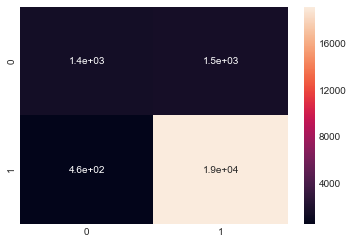

In [100]:
confusion_matrix_plot(y_test,pred)

### Word2Vec

### Best Hyperparameter No. of Base Learners using GridSearchCV

In [101]:
x_train, x_test, y_train, y_test = train_test_split(dt_data['Cleaned_Text'] ,dt_data['Score'], test_size=0.3, shuffle = False)

In [102]:
list_of_train_sent = []
for sent in x_train.values:
    list_of_train_sent.append(sent.split())

In [103]:
w2v_model = Word2Vec(list_of_train_sent,min_count=5,workers=4,size=100)
w2v_words = list(w2v_model.wv.vocab)

In [104]:
from tqdm import tqdm
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_train_sent): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            #print(sent_vec)
            cnt_words += 1
            #print(cnt_words)
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

100%|██████████| 52500/52500 [00:53<00:00, 985.92it/s] 


In [105]:
sent_vectors_arr = np.asarray(sent_vectors)
x_train = normalize(sent_vectors_arr)

In [106]:
list_of_test_sent = []
for sent in x_test.values:
    list_of_test_sent.append(sent.split())

In [107]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_test_sent): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            #print(sent_vec)
            cnt_words += 1
            #print(cnt_words)
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

100%|██████████| 22500/22500 [00:27<00:00, 816.42it/s] 


In [108]:
sent_vectors_arr = np.asarray(sent_vectors)
x_test = normalize(sent_vectors_arr)

### Random Forest

In [109]:
rf = RandomForestClassifier()
time_split_cv = TimeSeriesSplit(n_splits = 3)
base_learners = [i*10 for i in range(1,11)]
param_grid = {'n_estimators':base_learners}
grid_search = GridSearchCV(rf,param_grid,cv=time_split_cv,verbose=10,n_jobs= -1)
grid_search.fit(x_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=10 .................................................
[CV] n_estimators=10 .................................................
[CV] n_estimators=10 .................................................
[CV] n_estimators=20 .................................................
[CV] n_estimators=20 .................................................
[CV] n_estimators=20 .................................................
[CV] n_estimators=30 .................................................
[CV] n_estimators=30 .................................................
[CV] ........ n_estimators=10, score=0.8962285714285714, total=   2.3s
[CV] n_estimators=30 .................................................
[CV] ........ n_estimators=20, score=0.8999619047619047, total=   4.7s
[CV] n_estimators=40 .................................................


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s


[CV] ........ n_estimators=10, score=0.9002666666666667, total=   5.4s
[CV] n_estimators=40 .................................................
[CV] ........ n_estimators=30, score=0.9010285714285714, total=   6.9s
[CV] n_estimators=40 .................................................
[CV] ........ n_estimators=10, score=0.8871619047619047, total=   8.6s
[CV] n_estimators=50 .................................................
[CV] ........ n_estimators=20, score=0.9044571428571428, total=  10.8s
[CV] n_estimators=50 .................................................
[CV] ........ n_estimators=40, score=0.9008761904761905, total=   9.4s
[CV] n_estimators=50 .................................................
[CV] ........ n_estimators=30, score=0.9027047619047619, total=  16.5s
[CV] n_estimators=60 .................................................
[CV] ........ n_estimators=20, score=0.8929523809523809, total=  17.8s
[CV] n_estimators=60 .................................................


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   18.6s


[CV] ........ n_estimators=50, score=0.9003428571428571, total=  12.0s
[CV] n_estimators=60 .................................................
[CV] ........ n_estimators=40, score=0.9030095238095238, total=  21.9s
[CV] n_estimators=70 .................................................
[CV] ........ n_estimators=30, score=0.8931809523809524, total=  26.7s
[CV] n_estimators=70 .................................................
[CV] ........ n_estimators=60, score=0.9005714285714286, total=  14.0s
[CV] n_estimators=70 .................................................
[CV] ......... n_estimators=50, score=0.902552380952381, total=  28.3s
[CV] n_estimators=80 .................................................
[CV] ........ n_estimators=40, score=0.8931809523809524, total=  36.0s
[CV] n_estimators=80 .................................................
[CV] ........ n_estimators=70, score=0.8998857142857143, total=  16.8s
[CV] n_estimators=80 .................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:   59.6s remaining:   34.5s


[CV] ........ n_estimators=70, score=0.9030095238095238, total=  38.0s
[CV] n_estimators=100 ................................................
[CV] ........ n_estimators=90, score=0.8993523809523809, total=  21.1s
[CV] n_estimators=100 ................................................
[CV] ........ n_estimators=60, score=0.8921142857142857, total=  53.0s
[CV] n_estimators=100 ................................................
[CV] ........ n_estimators=80, score=0.9034666666666666, total=  42.1s


[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  1.4min remaining:   26.4s


[CV] ....... n_estimators=100, score=0.8986666666666666, total=  22.7s
[CV] ........ n_estimators=70, score=0.8915809523809524, total= 1.0min
[CV] ........ n_estimators=90, score=0.9030857142857143, total=  43.2s
[CV] ......... n_estimators=80, score=0.891352380952381, total= 1.0min


[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  1.8min remaining:   12.0s


[CV] ....... n_estimators=100, score=0.9017142857142857, total=  41.1s
[CV] ........ n_estimators=90, score=0.8915809523809524, total= 1.0min
[CV] ....... n_estimators=100, score=0.8911238095238095, total= 1.0min


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.3min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=10)

In [110]:
save_data(grid_search,'w2v_grid_search_rf')

In [111]:
a1 = load_data('w2v_grid_search_rf')

In [112]:
print('Best No. of Base Learners ',a1.best_params_['n_estimators'])
print('Best Accuracy %f% %'%(a1.best_score_*100))

Best No. of Base Learners  20
Best Accuracy 89.912381%


In [113]:
from sklearn.metrics import accuracy_score
rf_optimal = RandomForestClassifier(n_estimators = a1.best_params_['n_estimators'])
rf_optimal.fit(x_train, y_train)
pred = rf_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [114]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,88.955556,0.895446,0.988453,0.939654


True Positive 19347
True Negative 668
False Positive 2259
False Negative 226


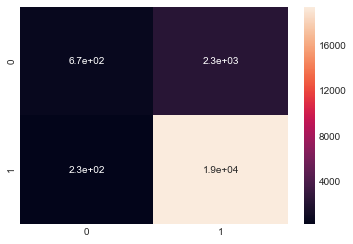

In [115]:
confusion_matrix_plot(y_test,pred)

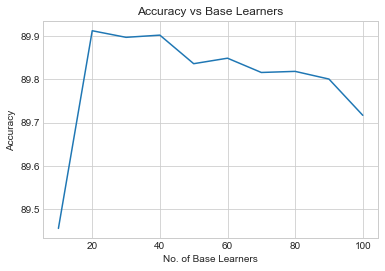

In [116]:
acc_vs_base_learners_plot(base_learners,a1.cv_results_['mean_test_score']*100)

### Gradient Boosted Decision Tree

In [118]:
gbdt = XGBClassifier()
time_split_cv = TimeSeriesSplit(n_splits = 3)
max_depth_list = sorted(np.random.randint(1,10,3))
base_learners = [i*10 for i in range(1,8)]
learning_rate_param = [i/10 for i in range(1,8)]
param_grid = {'n_estimators':base_learners,'max_depth':max_depth_list,'learning_rate':learning_rate_param}
grid_search = GridSearchCV(gbdt,param_grid,cv=time_split_cv,verbose=10,n_jobs= -1)
grid_search.fit(x_train,y_train)

Fitting 3 folds for each of 147 candidates, totalling 441 fits
[CV] learning_rate=0.1, max_depth=2, n_estimators=10 .................
[CV] learning_rate=0.1, max_depth=2, n_estimators=10 .................
[CV] learning_rate=0.1, max_depth=2, n_estimators=10 .................
[CV] learning_rate=0.1, max_depth=2, n_estimators=20 .................
[CV] learning_rate=0.1, max_depth=2, n_estimators=20 .................
[CV] learning_rate=0.1, max_depth=2, n_estimators=20 .................
[CV] learning_rate=0.1, max_depth=2, n_estimators=30 .................
[CV] learning_rate=0.1, max_depth=2, n_estimators=30 .................
[CV]  learning_rate=0.1, max_depth=2, n_estimators=10, score=0.8892190476190476, total=   1.4s
[CV] learning_rate=0.1, max_depth=2, n_estimators=30 .................
[CV]  learning_rate=0.1, max_depth=2, n_estimators=20, score=0.889447619047619, total=   2.8s
[CV] learning_rate=0.1, max_depth=2, n_estimators=40 .................
[CV]  learning_rate=0.1, max_depth=2, 

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.2s


[CV]  learning_rate=0.1, max_depth=2, n_estimators=30, score=0.8908190476190476, total=   4.2s
[CV] learning_rate=0.1, max_depth=2, n_estimators=40 .................
[CV]  learning_rate=0.1, max_depth=2, n_estimators=10, score=0.8796190476190476, total=   4.7s
[CV] learning_rate=0.1, max_depth=2, n_estimators=50 .................
[CV]  learning_rate=0.1, max_depth=2, n_estimators=20, score=0.8896, total=   5.8s
[CV] learning_rate=0.1, max_depth=2, n_estimators=50 .................
[CV]  learning_rate=0.1, max_depth=2, n_estimators=40, score=0.8934095238095238, total=   5.4s
[CV] learning_rate=0.1, max_depth=2, n_estimators=50 .................
[CV]  learning_rate=0.1, max_depth=2, n_estimators=30, score=0.8904380952380953, total=   8.3s
[CV] learning_rate=0.1, max_depth=2, n_estimators=60 .................
[CV]  learning_rate=0.1, max_depth=2, n_estimators=20, score=0.8799238095238096, total=   8.6s
[CV] learning_rate=0.1, max_depth=2, n_estimators=60 .................


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.3s


[CV]  learning_rate=0.1, max_depth=2, n_estimators=50, score=0.8953904761904762, total=   6.7s
[CV] learning_rate=0.1, max_depth=2, n_estimators=60 .................
[CV]  learning_rate=0.1, max_depth=2, n_estimators=30, score=0.8808380952380952, total=  12.5s
[CV] learning_rate=0.1, max_depth=2, n_estimators=70 .................
[CV]  learning_rate=0.1, max_depth=2, n_estimators=40, score=0.893104761904762, total=  11.1s
[CV] learning_rate=0.1, max_depth=2, n_estimators=70 .................
[CV]  learning_rate=0.1, max_depth=2, n_estimators=60, score=0.8975238095238095, total=   8.1s
[CV] learning_rate=0.1, max_depth=2, n_estimators=70 .................
[CV]  learning_rate=0.1, max_depth=2, n_estimators=50, score=0.8960761904761905, total=  13.7s
[CV] learning_rate=0.1, max_depth=5, n_estimators=10 .................
[CV]  learning_rate=0.1, max_depth=2, n_estimators=40, score=0.8823619047619048, total=  16.8s
[CV] learning_rate=0.1, max_depth=5, n_estimators=10 .................
[CV] 

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   23.8s


[CV]  learning_rate=0.1, max_depth=2, n_estimators=70, score=0.8992, total=   9.6s
[CV] learning_rate=0.1, max_depth=5, n_estimators=20 .................
[CV]  learning_rate=0.1, max_depth=2, n_estimators=60, score=0.8979047619047619, total=  16.7s
[CV] learning_rate=0.1, max_depth=5, n_estimators=20 .................
[CV]  learning_rate=0.1, max_depth=5, n_estimators=10, score=0.8991238095238095, total=   7.2s
[CV] learning_rate=0.1, max_depth=5, n_estimators=20 .................
[CV]  learning_rate=0.1, max_depth=2, n_estimators=50, score=0.8844190476190477, total=  21.1s
[CV] learning_rate=0.1, max_depth=5, n_estimators=30 .................
[CV]  learning_rate=0.1, max_depth=5, n_estimators=20, score=0.9011809523809524, total=   6.9s
[CV] learning_rate=0.1, max_depth=5, n_estimators=30 .................
[CV]  learning_rate=0.1, max_depth=2, n_estimators=70, score=0.9003428571428571, total=  19.8s
[CV] learning_rate=0.1, max_depth=5, n_estimators=30 .................
[CV]  learning_r

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   40.3s


[CV]  learning_rate=0.1, max_depth=5, n_estimators=30, score=0.9023238095238095, total=  10.4s
[CV] learning_rate=0.1, max_depth=5, n_estimators=50 .................
[CV]  learning_rate=0.1, max_depth=2, n_estimators=70, score=0.888, total=  29.9s
[CV] learning_rate=0.1, max_depth=5, n_estimators=50 .................
[CV]  learning_rate=0.1, max_depth=5, n_estimators=40, score=0.9044571428571428, total=  13.5s
[CV] learning_rate=0.1, max_depth=5, n_estimators=50 .................
[CV]  learning_rate=0.1, max_depth=5, n_estimators=20, score=0.891352380952381, total=  21.0s
[CV] learning_rate=0.1, max_depth=5, n_estimators=60 .................
[CV]  learning_rate=0.1, max_depth=5, n_estimators=30, score=0.9031619047619047, total=  20.6s
[CV] learning_rate=0.1, max_depth=5, n_estimators=60 .................
[CV]  learning_rate=0.1, max_depth=5, n_estimators=50, score=0.9068190476190476, total=  16.8s
[CV] learning_rate=0.1, max_depth=5, n_estimators=60 .................
[CV]  learning_rat

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min


[CV]  learning_rate=0.1, max_depth=5, n_estimators=50, score=0.9095619047619048, total=  33.2s
[CV]  learning_rate=0.1, max_depth=5, n_estimators=40, score=0.8956190476190476, total=  40.4s
[CV] learning_rate=0.1, max_depth=5, n_estimators=10 .................
[CV] learning_rate=0.1, max_depth=5, n_estimators=10 .................
[CV]  learning_rate=0.1, max_depth=5, n_estimators=10, score=0.8980571428571429, total=   3.5s
[CV] learning_rate=0.1, max_depth=5, n_estimators=10 .................
[CV]  learning_rate=0.1, max_depth=5, n_estimators=70, score=0.9084190476190476, total=  22.8s
[CV]  learning_rate=0.1, max_depth=5, n_estimators=10, score=0.8991238095238095, total=   6.9s
[CV] learning_rate=0.1, max_depth=5, n_estimators=20 .................
[CV] learning_rate=0.1, max_depth=5, n_estimators=20 .................
[CV]  learning_rate=0.1, max_depth=5, n_estimators=60, score=0.9101714285714285, total=  39.8s
[CV] learning_rate=0.1, max_depth=5, n_estimators=20 .................
[CV]

[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.7min


[CV]  learning_rate=0.1, max_depth=5, n_estimators=20, score=0.891352380952381, total=  20.3s
[CV] learning_rate=0.1, max_depth=5, n_estimators=40 .................
[CV]  learning_rate=0.1, max_depth=5, n_estimators=70, score=0.9115428571428571, total=  46.5s
[CV] learning_rate=0.1, max_depth=5, n_estimators=50 .................
[CV]  learning_rate=0.1, max_depth=5, n_estimators=40, score=0.9044571428571428, total=  13.6s
[CV] learning_rate=0.1, max_depth=5, n_estimators=50 .................
[CV]  learning_rate=0.1, max_depth=5, n_estimators=30, score=0.9031619047619047, total=  20.4s
[CV] learning_rate=0.1, max_depth=5, n_estimators=50 .................
[CV]  learning_rate=0.1, max_depth=5, n_estimators=60, score=0.8982857142857142, total= 1.0min
[CV] learning_rate=0.1, max_depth=5, n_estimators=60 .................
[CV]  learning_rate=0.1, max_depth=5, n_estimators=50, score=0.9068190476190476, total=  18.0s
[CV] learning_rate=0.1, max_depth=5, n_estimators=60 .................
[CV] 

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.6min


[CV]  learning_rate=0.2, max_depth=2, n_estimators=10, score=0.889752380952381, total=   2.0s
[CV] learning_rate=0.2, max_depth=2, n_estimators=10 .................
[CV]  learning_rate=0.1, max_depth=5, n_estimators=40, score=0.8956190476190476, total=  47.2s
[CV] learning_rate=0.2, max_depth=2, n_estimators=10 .................
[CV]  learning_rate=0.2, max_depth=2, n_estimators=10, score=0.8896, total=   3.3s
[CV] learning_rate=0.2, max_depth=2, n_estimators=20 .................
[CV]  learning_rate=0.1, max_depth=5, n_estimators=70, score=0.9084190476190476, total=  27.5s
[CV] learning_rate=0.2, max_depth=2, n_estimators=20 .................
[CV]  learning_rate=0.2, max_depth=2, n_estimators=20, score=0.8933333333333333, total=   2.9s
[CV] learning_rate=0.2, max_depth=2, n_estimators=20 .................
[CV]  learning_rate=0.2, max_depth=2, n_estimators=10, score=0.8796190476190476, total=   4.6s
[CV] learning_rate=0.2, max_depth=2, n_estimators=30 .................
[CV]  learning_ra

[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.0min


[CV]  learning_rate=0.2, max_depth=2, n_estimators=30, score=0.886552380952381, total=  13.6s
[CV] learning_rate=0.2, max_depth=2, n_estimators=50 .................
[CV]  learning_rate=0.2, max_depth=2, n_estimators=50, score=0.9023238095238095, total=   7.6s
[CV] learning_rate=0.2, max_depth=2, n_estimators=60 .................
[CV]  learning_rate=0.2, max_depth=2, n_estimators=40, score=0.9031619047619047, total=  11.8s
[CV] learning_rate=0.2, max_depth=2, n_estimators=60 .................
[CV]  learning_rate=0.2, max_depth=2, n_estimators=60, score=0.9036952380952381, total=   8.0s
[CV] learning_rate=0.2, max_depth=2, n_estimators=60 .................
[CV]  learning_rate=0.2, max_depth=2, n_estimators=50, score=0.9048380952380952, total=  14.2s
[CV] learning_rate=0.2, max_depth=2, n_estimators=70 .................
[CV]  learning_rate=0.1, max_depth=5, n_estimators=70, score=0.9115428571428571, total=  50.4s
[CV] learning_rate=0.2, max_depth=2, n_estimators=70 .................
[CV] 

[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.5min


[CV] learning_rate=0.2, max_depth=5, n_estimators=30 .................
[CV]  learning_rate=0.2, max_depth=2, n_estimators=70, score=0.9087238095238095, total=  18.6s
[CV] learning_rate=0.2, max_depth=5, n_estimators=30 .................
[CV]  learning_rate=0.2, max_depth=5, n_estimators=10, score=0.8900571428571429, total=  10.3s
[CV] learning_rate=0.2, max_depth=5, n_estimators=30 .................
[CV]  learning_rate=0.2, max_depth=2, n_estimators=60, score=0.8924952380952381, total=  24.1s
[CV] learning_rate=0.2, max_depth=5, n_estimators=40 .................
[CV]  learning_rate=0.2, max_depth=5, n_estimators=20, score=0.9061333333333333, total=  13.1s
[CV] learning_rate=0.2, max_depth=5, n_estimators=40 .................
[CV]  learning_rate=0.2, max_depth=5, n_estimators=30, score=0.9051428571428571, total=   9.7s
[CV] learning_rate=0.2, max_depth=5, n_estimators=40 .................
[CV]  learning_rate=0.1, max_depth=5, n_estimators=70, score=0.8983619047619048, total= 1.2min
[CV]

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  4.1min


[CV]  learning_rate=0.2, max_depth=5, n_estimators=50, score=0.9121523809523809, total=  32.4s
[CV] learning_rate=0.2, max_depth=5, n_estimators=10 .................
[CV]  learning_rate=0.2, max_depth=5, n_estimators=40, score=0.8973714285714286, total=  39.7s
[CV] learning_rate=0.2, max_depth=5, n_estimators=10 .................
[CV]  learning_rate=0.2, max_depth=5, n_estimators=10, score=0.9003428571428571, total=   3.4s
[CV] learning_rate=0.2, max_depth=5, n_estimators=10 .................
[CV]  learning_rate=0.2, max_depth=5, n_estimators=70, score=0.9068190476190476, total=  22.4s
[CV] learning_rate=0.2, max_depth=5, n_estimators=20 .................
[CV]  learning_rate=0.2, max_depth=5, n_estimators=10, score=0.9012571428571429, total=   7.0s
[CV] learning_rate=0.2, max_depth=5, n_estimators=20 .................
[CV]  learning_rate=0.2, max_depth=5, n_estimators=10, score=0.8900571428571429, total=  11.0s
[CV] learning_rate=0.2, max_depth=5, n_estimators=20 .................
[CV]

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  4.9min


[CV]  learning_rate=0.2, max_depth=5, n_estimators=60, score=0.8993523809523809, total= 1.0min
[CV] learning_rate=0.2, max_depth=5, n_estimators=60 .................
[CV]  learning_rate=0.2, max_depth=5, n_estimators=50, score=0.905752380952381, total=  16.7s
[CV] learning_rate=0.2, max_depth=5, n_estimators=60 .................
[CV]  learning_rate=0.2, max_depth=5, n_estimators=40, score=0.9102476190476191, total=  27.8s
[CV] learning_rate=0.2, max_depth=5, n_estimators=60 .................
[CV]  learning_rate=0.2, max_depth=5, n_estimators=30, score=0.8965333333333333, total=  31.4s
[CV] learning_rate=0.2, max_depth=5, n_estimators=70 .................
[CV]  learning_rate=0.2, max_depth=5, n_estimators=60, score=0.9061333333333333, total=  19.8s
[CV] learning_rate=0.2, max_depth=5, n_estimators=70 .................
[CV]  learning_rate=0.2, max_depth=5, n_estimators=70, score=0.9001904761904762, total= 1.2min
[CV] learning_rate=0.2, max_depth=5, n_estimators=70 .................
[CV] 

[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  5.8min


[CV]  learning_rate=0.2, max_depth=5, n_estimators=60, score=0.913752380952381, total=  43.7s
[CV] learning_rate=0.3, max_depth=2, n_estimators=40 .................
[CV]  learning_rate=0.3, max_depth=2, n_estimators=30, score=0.904, total=  11.5s
[CV] learning_rate=0.3, max_depth=2, n_estimators=50 .................
[CV]  learning_rate=0.3, max_depth=2, n_estimators=40, score=0.9037714285714286, total=   6.5s
[CV] learning_rate=0.3, max_depth=2, n_estimators=50 .................
[CV]  learning_rate=0.3, max_depth=2, n_estimators=30, score=0.8920380952380952, total=  15.8s
[CV] learning_rate=0.3, max_depth=2, n_estimators=50 .................
[CV]  learning_rate=0.3, max_depth=2, n_estimators=50, score=0.9042285714285714, total=   7.0s
[CV] learning_rate=0.3, max_depth=2, n_estimators=60 .................
[CV]  learning_rate=0.3, max_depth=2, n_estimators=40, score=0.9070476190476191, total=  11.8s
[CV] learning_rate=0.3, max_depth=2, n_estimators=60 .................
[CV]  learning_rat

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.5min


[CV]  learning_rate=0.3, max_depth=2, n_estimators=70, score=0.9104, total=  19.5s
[CV] learning_rate=0.3, max_depth=5, n_estimators=30 .................
[CV]  learning_rate=0.3, max_depth=5, n_estimators=10, score=0.8920380952380952, total=  10.4s
[CV] learning_rate=0.3, max_depth=5, n_estimators=30 .................
[CV]  learning_rate=0.3, max_depth=2, n_estimators=60, score=0.8955428571428572, total=  25.4s
[CV] learning_rate=0.3, max_depth=5, n_estimators=40 .................
[CV]  learning_rate=0.3, max_depth=5, n_estimators=20, score=0.908647619047619, total=  13.6s
[CV] learning_rate=0.3, max_depth=5, n_estimators=40 .................
[CV]  learning_rate=0.2, max_depth=5, n_estimators=70, score=0.9001904761904762, total= 1.3min
[CV] learning_rate=0.3, max_depth=5, n_estimators=40 .................
[CV]  learning_rate=0.3, max_depth=5, n_estimators=30, score=0.9058285714285714, total=  10.0s
[CV] learning_rate=0.3, max_depth=5, n_estimators=50 .................
[CV]  learning_ra

[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  7.4min


[CV]  learning_rate=0.3, max_depth=5, n_estimators=10, score=0.8920380952380952, total=  11.9s
[CV]  learning_rate=0.3, max_depth=5, n_estimators=60, score=0.9102476190476191, total=  42.4s
[CV] learning_rate=0.3, max_depth=5, n_estimators=20 .................
[CV] learning_rate=0.3, max_depth=5, n_estimators=30 .................
[CV]  learning_rate=0.3, max_depth=5, n_estimators=20, score=0.9033904761904762, total=   7.0s
[CV] learning_rate=0.3, max_depth=5, n_estimators=30 .................
[CV]  learning_rate=0.3, max_depth=5, n_estimators=50, score=0.9004190476190477, total=  53.1s
[CV] learning_rate=0.3, max_depth=5, n_estimators=30 .................
[CV]  learning_rate=0.3, max_depth=5, n_estimators=20, score=0.908647619047619, total=  13.9s
[CV] learning_rate=0.3, max_depth=5, n_estimators=40 .................
[CV]  learning_rate=0.3, max_depth=5, n_estimators=30, score=0.9058285714285714, total=  10.1s
[CV] learning_rate=0.3, max_depth=5, n_estimators=40 .................
[CV] 

[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.6min


[CV] learning_rate=0.4, max_depth=2, n_estimators=20 .................
[CV]  learning_rate=0.3, max_depth=5, n_estimators=70, score=0.9081904761904762, total=  25.5s
[CV] learning_rate=0.4, max_depth=2, n_estimators=20 .................
[CV]  learning_rate=0.4, max_depth=2, n_estimators=20, score=0.9000380952380952, total=   3.1s
[CV] learning_rate=0.4, max_depth=2, n_estimators=20 .................
[CV]  learning_rate=0.4, max_depth=2, n_estimators=10, score=0.8845714285714286, total=   4.9s
[CV] learning_rate=0.4, max_depth=2, n_estimators=30 .................
[CV]  learning_rate=0.4, max_depth=2, n_estimators=20, score=0.9016380952380952, total=   6.0s
[CV] learning_rate=0.4, max_depth=2, n_estimators=30 .................
[CV]  learning_rate=0.4, max_depth=2, n_estimators=30, score=0.9036952380952381, total=   4.5s
[CV] learning_rate=0.4, max_depth=2, n_estimators=30 .................
[CV]  learning_rate=0.4, max_depth=2, n_estimators=20, score=0.8905904761904762, total=   8.9s
[CV]

[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  9.3min


[CV]  learning_rate=0.4, max_depth=2, n_estimators=50, score=0.8976761904761905, total=  20.7s
[CV] learning_rate=0.4, max_depth=5, n_estimators=20 .................
[CV]  learning_rate=0.4, max_depth=5, n_estimators=10, score=0.9030857142857143, total=   7.0s
[CV] learning_rate=0.4, max_depth=5, n_estimators=20 .................
[CV]  learning_rate=0.4, max_depth=5, n_estimators=20, score=0.904, total=   6.7s
[CV] learning_rate=0.4, max_depth=5, n_estimators=30 .................
[CV]  learning_rate=0.4, max_depth=2, n_estimators=70, score=0.9095619047619048, total=  18.7s
[CV] learning_rate=0.4, max_depth=5, n_estimators=30 .................
[CV]  learning_rate=0.4, max_depth=5, n_estimators=10, score=0.8929523809523809, total=  10.5s
[CV] learning_rate=0.4, max_depth=5, n_estimators=30 .................
[CV]  learning_rate=0.4, max_depth=2, n_estimators=60, score=0.8982857142857142, total=  24.5s
[CV] learning_rate=0.4, max_depth=5, n_estimators=40 .................
[CV]  learning_ra

[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed: 10.3min


[CV]  learning_rate=0.4, max_depth=5, n_estimators=70, score=0.9049142857142857, total=  24.4s
[CV] learning_rate=0.4, max_depth=5, n_estimators=20 .................
[CV]  learning_rate=0.4, max_depth=5, n_estimators=10, score=0.9030857142857143, total=   7.2s
[CV] learning_rate=0.4, max_depth=5, n_estimators=20 .................
[CV]  learning_rate=0.4, max_depth=5, n_estimators=10, score=0.8929523809523809, total=  11.3s
[CV] learning_rate=0.4, max_depth=5, n_estimators=20 .................
[CV]  learning_rate=0.4, max_depth=5, n_estimators=60, score=0.9084190476190476, total=  42.5s
[CV] learning_rate=0.4, max_depth=5, n_estimators=30 .................
[CV]  learning_rate=0.4, max_depth=5, n_estimators=20, score=0.904, total=   7.3s
[CV] learning_rate=0.4, max_depth=5, n_estimators=30 .................
[CV]  learning_rate=0.4, max_depth=5, n_estimators=50, score=0.8975238095238095, total=  53.4s
[CV] learning_rate=0.4, max_depth=5, n_estimators=30 .................
[CV]  learning_ra

[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed: 11.6min


[CV]  learning_rate=0.5, max_depth=2, n_estimators=20, score=0.9030857142857143, total=   3.0s
[CV] learning_rate=0.5, max_depth=2, n_estimators=20 .................
[CV]  learning_rate=0.5, max_depth=2, n_estimators=10, score=0.8859428571428571, total=   5.0s
[CV] learning_rate=0.5, max_depth=2, n_estimators=30 .................
[CV]  learning_rate=0.5, max_depth=2, n_estimators=20, score=0.9039238095238096, total=   6.1s
[CV] learning_rate=0.5, max_depth=2, n_estimators=30 .................
[CV]  learning_rate=0.5, max_depth=2, n_estimators=30, score=0.9040761904761905, total=   4.4s
[CV] learning_rate=0.5, max_depth=2, n_estimators=30 .................
[CV]  learning_rate=0.5, max_depth=2, n_estimators=20, score=0.8923428571428571, total=   9.1s
[CV] learning_rate=0.5, max_depth=2, n_estimators=40 .................
[CV]  learning_rate=0.4, max_depth=5, n_estimators=50, score=0.8975238095238095, total=  51.2s
[CV] learning_rate=0.5, max_depth=2, n_estimators=40 .................
[CV]

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 12.4min


[CV]  learning_rate=0.5, max_depth=2, n_estimators=70, score=0.9091809523809524, total=  19.5s
[CV] learning_rate=0.5, max_depth=5, n_estimators=30 .................
[CV]  learning_rate=0.5, max_depth=5, n_estimators=10, score=0.8943238095238095, total=  11.5s
[CV] learning_rate=0.5, max_depth=5, n_estimators=30 .................
[CV]  learning_rate=0.5, max_depth=2, n_estimators=60, score=0.8964571428571428, total=  26.5s
[CV] learning_rate=0.5, max_depth=5, n_estimators=40 .................
[CV]  learning_rate=0.5, max_depth=5, n_estimators=20, score=0.9072761904761905, total=  15.9s
[CV] learning_rate=0.5, max_depth=5, n_estimators=40 .................
[CV]  learning_rate=0.5, max_depth=5, n_estimators=30, score=0.9031619047619047, total=  12.0s
[CV] learning_rate=0.5, max_depth=5, n_estimators=40 .................
[CV]  learning_rate=0.4, max_depth=5, n_estimators=70, score=0.8966857142857143, total= 1.2min
[CV] learning_rate=0.5, max_depth=5, n_estimators=50 .................
[CV]

[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed: 13.7min


[CV]  learning_rate=0.5, max_depth=5, n_estimators=20, score=0.8969904761904762, total=  23.5s
[CV]  learning_rate=0.5, max_depth=5, n_estimators=70, score=0.9078095238095238, total=  52.1s
[CV] learning_rate=0.5, max_depth=5, n_estimators=40 .................
[CV] learning_rate=0.5, max_depth=5, n_estimators=50 .................
[CV]  learning_rate=0.5, max_depth=5, n_estimators=30, score=0.9084952380952381, total=  22.2s
[CV] learning_rate=0.5, max_depth=5, n_estimators=50 .................
[CV]  learning_rate=0.5, max_depth=5, n_estimators=40, score=0.9052190476190476, total=  14.6s
[CV] learning_rate=0.5, max_depth=5, n_estimators=50 .................
[CV]  learning_rate=0.5, max_depth=5, n_estimators=60, score=0.8987428571428572, total= 1.1min
[CV] learning_rate=0.5, max_depth=5, n_estimators=60 .................
[CV]  learning_rate=0.5, max_depth=5, n_estimators=50, score=0.9043809523809524, total=  17.4s
[CV] learning_rate=0.5, max_depth=5, n_estimators=60 .................
[CV]

[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed: 15.0min


[CV]  learning_rate=0.6, max_depth=2, n_estimators=50, score=0.9042285714285714, total=   7.2s
[CV] learning_rate=0.6, max_depth=2, n_estimators=60 .................
[CV]  learning_rate=0.6, max_depth=2, n_estimators=40, score=0.9094857142857142, total=  11.9s
[CV] learning_rate=0.6, max_depth=2, n_estimators=60 .................
[CV]  learning_rate=0.5, max_depth=5, n_estimators=70, score=0.9078095238095238, total=  49.1s
[CV] learning_rate=0.6, max_depth=2, n_estimators=60 .................
[CV]  learning_rate=0.6, max_depth=2, n_estimators=60, score=0.9027809523809524, total=   8.4s
[CV] learning_rate=0.6, max_depth=2, n_estimators=70 .................
[CV]  learning_rate=0.6, max_depth=2, n_estimators=50, score=0.9094857142857142, total=  14.6s
[CV] learning_rate=0.6, max_depth=2, n_estimators=70 .................
[CV]  learning_rate=0.6, max_depth=2, n_estimators=40, score=0.8937142857142857, total=  17.6s
[CV] learning_rate=0.6, max_depth=2, n_estimators=70 .................
[CV]

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 16.2min


[CV]  learning_rate=0.6, max_depth=5, n_estimators=50, score=0.9067428571428572, total=  36.3s
[CV] learning_rate=0.6, max_depth=5, n_estimators=10 .................
[CV]  learning_rate=0.6, max_depth=5, n_estimators=10, score=0.8995047619047619, total=   3.7s
[CV] learning_rate=0.6, max_depth=5, n_estimators=10 .................
[CV]  learning_rate=0.6, max_depth=5, n_estimators=40, score=0.8966857142857143, total=  44.3s
[CV] learning_rate=0.6, max_depth=5, n_estimators=10 .................
[CV]  learning_rate=0.6, max_depth=5, n_estimators=70, score=0.9036952380952381, total=  24.6s
[CV] learning_rate=0.6, max_depth=5, n_estimators=20 .................
[CV]  learning_rate=0.6, max_depth=5, n_estimators=10, score=0.9058285714285714, total=   7.6s
[CV] learning_rate=0.6, max_depth=5, n_estimators=20 .................
[CV]  learning_rate=0.6, max_depth=5, n_estimators=10, score=0.8911238095238095, total=  11.5s
[CV] learning_rate=0.6, max_depth=5, n_estimators=20 .................
[CV]

[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed: 17.8min


[CV]  learning_rate=0.7, max_depth=2, n_estimators=10, score=0.8904380952380953, total=   5.3s
[CV] learning_rate=0.7, max_depth=2, n_estimators=30 .................
[CV]  learning_rate=0.7, max_depth=2, n_estimators=20, score=0.905295238095238, total=   6.2s
[CV] learning_rate=0.7, max_depth=2, n_estimators=30 .................
[CV]  learning_rate=0.7, max_depth=2, n_estimators=30, score=0.9023238095238095, total=   4.5s
[CV] learning_rate=0.7, max_depth=2, n_estimators=30 .................
[CV]  learning_rate=0.7, max_depth=2, n_estimators=20, score=0.8924952380952381, total=   9.3s
[CV] learning_rate=0.7, max_depth=2, n_estimators=40 .................
[CV]  learning_rate=0.6, max_depth=5, n_estimators=50, score=0.8973714285714286, total=  54.0s
[CV] learning_rate=0.7, max_depth=2, n_estimators=40 .................
[CV]  learning_rate=0.7, max_depth=2, n_estimators=30, score=0.9072761904761905, total=   9.1s
[CV] learning_rate=0.7, max_depth=2, n_estimators=40 .................
[CV] 

[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed: 18.8min


[CV]  learning_rate=0.7, max_depth=5, n_estimators=20, score=0.8932571428571429, total=  20.7s
[CV] learning_rate=0.7, max_depth=5, n_estimators=50 .................
[CV]  learning_rate=0.7, max_depth=5, n_estimators=40, score=0.8993523809523809, total=  13.2s
[CV] learning_rate=0.7, max_depth=5, n_estimators=60 .................
[CV]  learning_rate=0.7, max_depth=5, n_estimators=30, score=0.9032380952380953, total=  20.3s
[CV] learning_rate=0.7, max_depth=5, n_estimators=60 .................
[CV]  learning_rate=0.7, max_depth=5, n_estimators=50, score=0.8989714285714285, total=  16.3s
[CV] learning_rate=0.7, max_depth=5, n_estimators=60 .................
[CV]  learning_rate=0.7, max_depth=5, n_estimators=30, score=0.8930285714285714, total=  30.5s
[CV] learning_rate=0.7, max_depth=5, n_estimators=70 .................
[CV]  learning_rate=0.7, max_depth=5, n_estimators=40, score=0.9048380952380952, total=  26.3s
[CV] learning_rate=0.7, max_depth=5, n_estimators=70 .................
[CV]

[Parallel(n_jobs=-1)]: Done 441 out of 441 | elapsed: 21.2min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70], 'max_depth': [2, 5, 5], 'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=10)

In [119]:
save_data(grid_search,'w2v_grid_search_gbdt')

In [120]:
a1 = load_data('w2v_grid_search_gbdt')

In [121]:
print('Best No. of Base Learners is %d, Max. Depth is %d and Learning Rate is %0.2f'%(a1.best_params_['n_estimators'],a1.best_params_['max_depth'],a1.best_params_['learning_rate']))
print('Best Accuracy %f% %'%(a1.best_score_*100))

Best No. of Base Learners is 70, Max. Depth is 5 and Learning Rate is 0.20
Best Accuracy 90.671746%


In [122]:
from sklearn.metrics import accuracy_score
gbdt_optimal = XGBClassifier(n_estimators = a1.best_params_['n_estimators'],max_depth =a1.best_params_['max_depth'],learning_rate = a1.best_params_['learning_rate'])
gbdt_optimal.fit(x_train, y_train)
pred = gbdt_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [123]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,90.151111,0.914941,0.977673,0.945268


True Positive 19136
True Negative 1148
False Positive 1779
False Negative 437


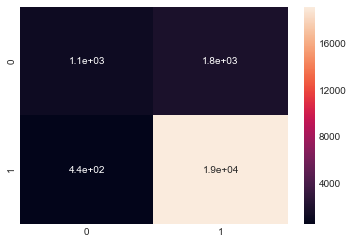

In [124]:
confusion_matrix_plot(y_test,pred)

### Average TfIdf Weighted Word2Vec

### Random Forest

### Best Hyperparameter No. of Base Learners using GridSearchCV

In [125]:
x_train, x_test, y_train, y_test = train_test_split(dt_data['Cleaned_Text'],dt_data['Score'], test_size=0.3, random_state=0)

In [128]:
x_train = load_data('../Amazon_Food_Review_Decision_Trees/tfidf_w2v_train_set_dt')
x_test = load_data('../Amazon_Food_Review_Decision_Trees/tfidf_w2v_test_set_dt')

In [129]:
rf = RandomForestClassifier()
time_split_cv = TimeSeriesSplit(n_splits = 3)
base_learners = [i*10 for i in range(1,11)]
param_grid = {'n_estimators':base_learners}
grid_search = GridSearchCV(rf,param_grid,cv=time_split_cv,verbose=10,n_jobs= -1)
grid_search.fit(x_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=10 .................................................
[CV] n_estimators=10 .................................................
[CV] n_estimators=10 .................................................
[CV] n_estimators=20 .................................................
[CV] n_estimators=20 .................................................
[CV] n_estimators=20 .................................................
[CV] n_estimators=30 .................................................
[CV] n_estimators=30 .................................................
[CV] ........ n_estimators=10, score=0.8728380952380952, total=   5.4s
[CV] n_estimators=30 .................................................
[CV] ...................... n_estimators=20, score=0.88, total=  10.3s
[CV] n_estimators=40 .................................................


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.8s


[CV] ........ n_estimators=10, score=0.8721523809523809, total=  11.6s
[CV] n_estimators=40 .................................................
[CV] ........ n_estimators=30, score=0.8806095238095238, total=  15.9s
[CV] n_estimators=40 .................................................
[CV] ........ n_estimators=10, score=0.8732952380952381, total=  23.0s
[CV] n_estimators=50 .................................................
[CV] ........ n_estimators=20, score=0.8799238095238096, total=  24.4s
[CV] n_estimators=50 .................................................
[CV] ........ n_estimators=40, score=0.8809142857142858, total=  21.5s
[CV] n_estimators=50 .................................................
[CV] ........ n_estimators=30, score=0.8813714285714286, total=  36.8s
[CV] n_estimators=60 .................................................
[CV] ........ n_estimators=20, score=0.8791619047619048, total=  47.0s
[CV] n_estimators=60 .................................................


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   48.0s


[CV] ........ n_estimators=50, score=0.8808380952380952, total=  29.3s
[CV] n_estimators=60 .................................................
[CV] ......... n_estimators=40, score=0.881447619047619, total=  53.5s
[CV] n_estimators=70 .................................................
[CV] ........ n_estimators=60, score=0.8809142857142858, total=  35.3s
[CV] n_estimators=70 .................................................
[CV] ........ n_estimators=30, score=0.8803047619047619, total= 1.2min
[CV] n_estimators=70 .................................................
[CV] ........ n_estimators=50, score=0.8815238095238095, total= 1.1min
[CV] n_estimators=80 .................................................
[CV] ........ n_estimators=70, score=0.8809904761904762, total=  37.7s
[CV] n_estimators=80 .................................................
[CV] ........ n_estimators=40, score=0.8803047619047619, total= 1.5min
[CV] n_estimators=80 .................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  2.4min remaining:  1.4min


[CV] ......... n_estimators=70, score=0.881447619047619, total= 1.5min
[CV] n_estimators=100 ................................................
[CV] ........ n_estimators=90, score=0.8808380952380952, total=  51.5s
[CV] n_estimators=100 ................................................
[CV] ........ n_estimators=60, score=0.8805333333333333, total= 2.2min
[CV] n_estimators=100 ................................................
[CV] ......... n_estimators=80, score=0.881447619047619, total= 1.8min


[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  3.5min remaining:  1.1min


[CV] ....... n_estimators=100, score=0.8809904761904762, total=  56.1s
[CV] ........ n_estimators=70, score=0.8805333333333333, total= 2.6min
[CV] ........ n_estimators=90, score=0.8815238095238095, total= 1.9min
[CV] ........ n_estimators=80, score=0.8805333333333333, total= 2.7min


[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  4.4min remaining:   29.7s


[CV] ....... n_estimators=100, score=0.8815238095238095, total= 1.7min
[CV] ........ n_estimators=90, score=0.8804571428571428, total= 2.6min
[CV] ....... n_estimators=100, score=0.8804571428571428, total= 2.5min


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.6min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=10)

In [130]:
save_data(grid_search,'tfidf_w2v_grid_search_rf')

In [131]:
a1 = load_data('tfidf_w2v_grid_search_rf')

In [132]:
print('Best No. of Base Learners ',a1.best_params_['n_estimators'])
print('Best Accuracy %f% %'%(a1.best_score_*100))

Best No. of Base Learners  60
Best Accuracy 88.099048%


In [133]:
from sklearn.metrics import accuracy_score
rf_optimal = RandomForestClassifier(n_estimators = a1.best_params_['n_estimators'])
rf_optimal.fit(x_train, y_train)
pred = rf_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [134]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,88.222222,0.882458,0.999698,0.937426


True Positive 19850
True Negative 0
False Positive 2644
False Negative 6


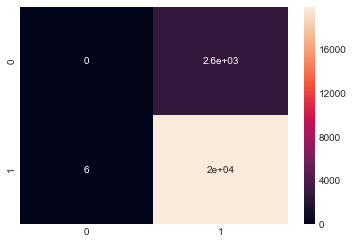

In [135]:
confusion_matrix_plot(y_test,pred)

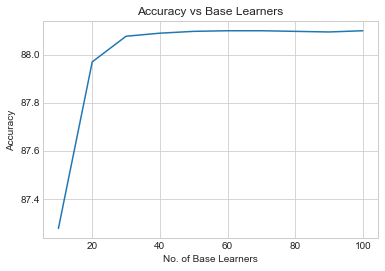

In [136]:
acc_vs_base_learners_plot(base_learners,a1.cv_results_['mean_test_score']*100)

### Gradient Boosted Decision Tree

In [137]:
gbdt = XGBClassifier()
time_split_cv = TimeSeriesSplit(n_splits = 3)
max_depth_list = sorted(np.random.randint(1,10,3))
base_learners = [i*10 for i in range(1,8)]
learning_rate_param = [i/10 for i in range(1,8)]
param_grid = {'n_estimators':base_learners,'max_depth':max_depth_list,'learning_rate':learning_rate_param}
grid_search = GridSearchCV(gbdt,param_grid,cv=time_split_cv,verbose=10,n_jobs= -1)
grid_search.fit(x_train,y_train)

Fitting 3 folds for each of 147 candidates, totalling 441 fits
[CV] learning_rate=0.1, max_depth=4, n_estimators=10 .................
[CV] learning_rate=0.1, max_depth=4, n_estimators=10 .................
[CV] learning_rate=0.1, max_depth=4, n_estimators=10 .................
[CV] learning_rate=0.1, max_depth=4, n_estimators=20 .................
[CV] learning_rate=0.1, max_depth=4, n_estimators=20 .................
[CV] learning_rate=0.1, max_depth=4, n_estimators=20 .................
[CV] learning_rate=0.1, max_depth=4, n_estimators=30 .................
[CV] learning_rate=0.1, max_depth=4, n_estimators=30 .................
[CV]  learning_rate=0.1, max_depth=4, n_estimators=10, score=0.8811428571428571, total=   2.5s
[CV] learning_rate=0.1, max_depth=4, n_estimators=30 .................
[CV]  learning_rate=0.1, max_depth=4, n_estimators=20, score=0.8812190476190476, total=   5.1s
[CV] learning_rate=0.1, max_depth=4, n_estimators=40 .................
[CV]  learning_rate=0.1, max_depth=4,

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.5s


[CV] learning_rate=0.1, max_depth=4, n_estimators=40 .................
[CV]  learning_rate=0.1, max_depth=4, n_estimators=30, score=0.8812190476190476, total=   7.5s
[CV] learning_rate=0.1, max_depth=4, n_estimators=40 .................
[CV]  learning_rate=0.1, max_depth=4, n_estimators=10, score=0.8807619047619047, total=   8.2s
[CV] learning_rate=0.1, max_depth=4, n_estimators=50 .................
[CV]  learning_rate=0.1, max_depth=4, n_estimators=20, score=0.881752380952381, total=  10.3s
[CV] learning_rate=0.1, max_depth=4, n_estimators=50 .................
[CV]  learning_rate=0.1, max_depth=4, n_estimators=40, score=0.8812190476190476, total=   9.8s
[CV] learning_rate=0.1, max_depth=4, n_estimators=50 .................
[CV]  learning_rate=0.1, max_depth=4, n_estimators=30, score=0.881752380952381, total=  15.0s
[CV] learning_rate=0.1, max_depth=4, n_estimators=60 .................
[CV]  learning_rate=0.1, max_depth=4, n_estimators=20, score=0.8808380952380952, total=  15.4s
[CV] l

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   16.1s


[CV]  learning_rate=0.1, max_depth=4, n_estimators=50, score=0.8812190476190476, total=  12.1s
[CV] learning_rate=0.1, max_depth=4, n_estimators=60 .................
[CV]  learning_rate=0.1, max_depth=4, n_estimators=30, score=0.8808380952380952, total=  22.8s
[CV] learning_rate=0.1, max_depth=4, n_estimators=70 .................
[CV]  learning_rate=0.1, max_depth=4, n_estimators=40, score=0.8816761904761905, total=  20.1s
[CV] learning_rate=0.1, max_depth=4, n_estimators=70 .................
[CV]  learning_rate=0.1, max_depth=4, n_estimators=60, score=0.8812190476190476, total=  15.2s
[CV] learning_rate=0.1, max_depth=4, n_estimators=70 .................
[CV]  learning_rate=0.1, max_depth=4, n_estimators=50, score=0.881752380952381, total=  25.6s
[CV] learning_rate=0.1, max_depth=6, n_estimators=10 .................
[CV]  learning_rate=0.1, max_depth=4, n_estimators=40, score=0.8808380952380952, total=  30.9s
[CV] learning_rate=0.1, max_depth=6, n_estimators=10 .................
[CV] 

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   40.8s


[CV]  learning_rate=0.1, max_depth=4, n_estimators=70, score=0.8812190476190476, total=  18.5s
[CV] learning_rate=0.1, max_depth=6, n_estimators=20 .................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=10, score=0.8816761904761905, total=   8.6s
[CV] learning_rate=0.1, max_depth=6, n_estimators=20 .................
[CV]  learning_rate=0.1, max_depth=4, n_estimators=60, score=0.8816761904761905, total=  31.7s
[CV] learning_rate=0.1, max_depth=6, n_estimators=20 .................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=20, score=0.8812190476190476, total=   8.5s
[CV] learning_rate=0.1, max_depth=6, n_estimators=30 .................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=10, score=0.8806857142857143, total=  13.3s
[CV] learning_rate=0.1, max_depth=6, n_estimators=30 .................
[CV]  learning_rate=0.1, max_depth=4, n_estimators=50, score=0.8808380952380952, total=  40.5s
[CV] learning_rate=0.1, max_depth=6, n_estimators=30 .................
[CV]

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min


[CV]  learning_rate=0.1, max_depth=4, n_estimators=60, score=0.8808380952380952, total=  49.4s
[CV] learning_rate=0.1, max_depth=6, n_estimators=50 .................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=20, score=0.8808380952380952, total=  25.4s
[CV] learning_rate=0.1, max_depth=6, n_estimators=50 .................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=30, score=0.881752380952381, total=  24.1s
[CV] learning_rate=0.1, max_depth=6, n_estimators=50 .................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=40, score=0.8812190476190476, total=  15.4s
[CV] learning_rate=0.1, max_depth=6, n_estimators=60 .................
[CV]  learning_rate=0.1, max_depth=4, n_estimators=70, score=0.8808380952380952, total=  57.2s
[CV] learning_rate=0.1, max_depth=6, n_estimators=60 .................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=50, score=0.8812190476190476, total=  19.0s
[CV] learning_rate=0.1, max_depth=6, n_estimators=60 .................
[CV] 

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min


[CV]  learning_rate=0.1, max_depth=6, n_estimators=40, score=0.8808380952380952, total=  47.0s
[CV] learning_rate=0.1, max_depth=7, n_estimators=10 .................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=50, score=0.8816761904761905, total=  39.0s
[CV] learning_rate=0.1, max_depth=7, n_estimators=10 .................
[CV]  learning_rate=0.1, max_depth=7, n_estimators=10, score=0.8809904761904762, total=   4.5s
[CV] learning_rate=0.1, max_depth=7, n_estimators=10 .................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=70, score=0.8812190476190476, total=  26.7s
[CV] learning_rate=0.1, max_depth=7, n_estimators=20 .................
[CV]  learning_rate=0.1, max_depth=7, n_estimators=10, score=0.8816761904761905, total=   9.6s
[CV] learning_rate=0.1, max_depth=7, n_estimators=20 .................
[CV]  learning_rate=0.1, max_depth=7, n_estimators=20, score=0.8812190476190476, total=   9.4s
[CV] learning_rate=0.1, max_depth=7, n_estimators=20 .................
[CV]

[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.5min


[CV]  learning_rate=0.1, max_depth=6, n_estimators=70, score=0.8816761904761905, total=  59.6s
[CV] learning_rate=0.1, max_depth=7, n_estimators=40 .................
[CV]  learning_rate=0.1, max_depth=7, n_estimators=20, score=0.8808380952380952, total=  32.4s
[CV] learning_rate=0.1, max_depth=7, n_estimators=50 .................
[CV]  learning_rate=0.1, max_depth=7, n_estimators=40, score=0.8812190476190476, total=  19.3s
[CV] learning_rate=0.1, max_depth=7, n_estimators=50 .................
[CV]  learning_rate=0.1, max_depth=6, n_estimators=60, score=0.8808380952380952, total= 1.3min
[CV] learning_rate=0.1, max_depth=7, n_estimators=50 .................
[CV]  learning_rate=0.1, max_depth=7, n_estimators=30, score=0.881752380952381, total=  30.4s
[CV] learning_rate=0.1, max_depth=7, n_estimators=60 .................
[CV]  learning_rate=0.1, max_depth=7, n_estimators=50, score=0.8812190476190476, total=  22.3s
[CV] learning_rate=0.1, max_depth=7, n_estimators=60 .................
[CV] 

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.5min


[CV]  learning_rate=0.1, max_depth=7, n_estimators=40, score=0.8808380952380952, total=  55.9s
[CV] learning_rate=0.2, max_depth=4, n_estimators=10 .................
[CV]  learning_rate=0.2, max_depth=4, n_estimators=10, score=0.8812190476190476, total=   2.9s
[CV] learning_rate=0.2, max_depth=4, n_estimators=10 .................
[CV]  learning_rate=0.2, max_depth=4, n_estimators=10, score=0.881752380952381, total=   5.7s
[CV] learning_rate=0.2, max_depth=4, n_estimators=20 .................
[CV]  learning_rate=0.1, max_depth=7, n_estimators=70, score=0.8811428571428571, total=  32.4s
[CV] learning_rate=0.2, max_depth=4, n_estimators=20 .................
[CV]  learning_rate=0.2, max_depth=4, n_estimators=10, score=0.8808380952380952, total=   8.9s
[CV] learning_rate=0.2, max_depth=4, n_estimators=20 .................
[CV]  learning_rate=0.2, max_depth=4, n_estimators=20, score=0.8812190476190476, total=   5.7s
[CV] learning_rate=0.2, max_depth=4, n_estimators=30 .................
[CV] 

[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.1min


[CV]  learning_rate=0.1, max_depth=7, n_estimators=70, score=0.881752380952381, total= 1.1min
[CV] learning_rate=0.2, max_depth=4, n_estimators=50 .................
[CV]  learning_rate=0.2, max_depth=4, n_estimators=30, score=0.8807619047619047, total=  25.9s
[CV] learning_rate=0.2, max_depth=4, n_estimators=60 .................
[CV]  learning_rate=0.2, max_depth=4, n_estimators=50, score=0.8810666666666667, total=  13.2s
[CV] learning_rate=0.2, max_depth=4, n_estimators=60 .................
[CV]  learning_rate=0.2, max_depth=4, n_estimators=40, score=0.881752380952381, total=  22.3s
[CV] learning_rate=0.2, max_depth=4, n_estimators=60 .................
[CV]  learning_rate=0.1, max_depth=7, n_estimators=60, score=0.8808380952380952, total= 1.4min
[CV] learning_rate=0.2, max_depth=4, n_estimators=70 .................
[CV]  learning_rate=0.2, max_depth=4, n_estimators=40, score=0.8807619047619047, total=  34.2s
[CV] learning_rate=0.2, max_depth=4, n_estimators=70 .................
[CV]  

[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  5.0min


[CV]  learning_rate=0.2, max_depth=6, n_estimators=20, score=0.8812190476190476, total=   8.7s
[CV] learning_rate=0.2, max_depth=6, n_estimators=30 .................
[CV]  learning_rate=0.2, max_depth=4, n_estimators=50, score=0.8807619047619047, total=  44.1s
[CV] learning_rate=0.2, max_depth=6, n_estimators=30 .................
[CV]  learning_rate=0.2, max_depth=6, n_estimators=10, score=0.8807619047619047, total=  13.6s
[CV] learning_rate=0.2, max_depth=6, n_estimators=30 .................
[CV]  learning_rate=0.2, max_depth=6, n_estimators=30, score=0.8812190476190476, total=  11.5s
[CV] learning_rate=0.2, max_depth=6, n_estimators=40 .................
[CV]  learning_rate=0.2, max_depth=6, n_estimators=20, score=0.8816761904761905, total=  15.9s
[CV] learning_rate=0.2, max_depth=6, n_estimators=40 .................
[CV]  learning_rate=0.2, max_depth=4, n_estimators=60, score=0.8807619047619047, total=  51.8s
[CV] learning_rate=0.2, max_depth=6, n_estimators=40 .................
[CV]

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  5.8min


[CV]  learning_rate=0.2, max_depth=6, n_estimators=40, score=0.8807619047619047, total=  46.6s
[CV] learning_rate=0.2, max_depth=7, n_estimators=10 .................
[CV]  learning_rate=0.2, max_depth=6, n_estimators=50, score=0.881447619047619, total=  38.5s
[CV] learning_rate=0.2, max_depth=7, n_estimators=10 .................
[CV]  learning_rate=0.2, max_depth=7, n_estimators=10, score=0.8810666666666667, total=   4.5s
[CV] learning_rate=0.2, max_depth=7, n_estimators=10 .................
[CV]  learning_rate=0.2, max_depth=6, n_estimators=70, score=0.8802285714285715, total=  26.0s
[CV] learning_rate=0.2, max_depth=7, n_estimators=20 .................
[CV]  learning_rate=0.2, max_depth=7, n_estimators=10, score=0.8816761904761905, total=   9.6s
[CV] learning_rate=0.2, max_depth=7, n_estimators=20 .................
[CV]  learning_rate=0.2, max_depth=7, n_estimators=20, score=0.8810666666666667, total=   9.3s
[CV] learning_rate=0.2, max_depth=7, n_estimators=20 .................
[CV] 

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  6.8min


[CV]  learning_rate=0.2, max_depth=7, n_estimators=40, score=0.8811428571428571, total=  17.5s
[CV] learning_rate=0.2, max_depth=7, n_estimators=60 .................
[CV]  learning_rate=0.2, max_depth=7, n_estimators=30, score=0.8805333333333333, total=  40.7s
[CV] learning_rate=0.2, max_depth=7, n_estimators=60 .................
[CV]  learning_rate=0.2, max_depth=7, n_estimators=50, score=0.8807619047619047, total=  22.6s
[CV] learning_rate=0.2, max_depth=7, n_estimators=60 .................
[CV]  learning_rate=0.2, max_depth=7, n_estimators=40, score=0.8816, total=  36.7s
[CV] learning_rate=0.2, max_depth=7, n_estimators=70 .................
[CV]  learning_rate=0.2, max_depth=6, n_estimators=70, score=0.8806857142857143, total= 1.4min
[CV] learning_rate=0.2, max_depth=7, n_estimators=70 .................
[CV]  learning_rate=0.2, max_depth=7, n_estimators=60, score=0.8805333333333333, total=  27.8s
[CV] learning_rate=0.2, max_depth=7, n_estimators=70 .................
[CV]  learning_r

[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  8.0min


[CV]  learning_rate=0.2, max_depth=7, n_estimators=60, score=0.8815238095238095, total=  54.0s
[CV] learning_rate=0.3, max_depth=4, n_estimators=40 .................
[CV]  learning_rate=0.3, max_depth=4, n_estimators=40, score=0.8807619047619047, total=  10.9s
[CV] learning_rate=0.3, max_depth=4, n_estimators=50 .................
[CV]  learning_rate=0.3, max_depth=4, n_estimators=30, score=0.8816, total=  16.5s
[CV] learning_rate=0.3, max_depth=4, n_estimators=50 .................
[CV]  learning_rate=0.2, max_depth=7, n_estimators=70, score=0.881447619047619, total= 1.1min
[CV] learning_rate=0.3, max_depth=4, n_estimators=50 .................
[CV]  learning_rate=0.3, max_depth=4, n_estimators=30, score=0.8807619047619047, total=  26.1s
[CV] learning_rate=0.3, max_depth=4, n_estimators=60 .................
[CV]  learning_rate=0.3, max_depth=4, n_estimators=50, score=0.8806095238095238, total=  15.0s
[CV] learning_rate=0.3, max_depth=4, n_estimators=60 .................
[CV]  learning_ra

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  9.0min


[CV]  learning_rate=0.3, max_depth=4, n_estimators=50, score=0.8806857142857143, total=  42.2s
[CV] learning_rate=0.3, max_depth=6, n_estimators=30 .................
[CV]  learning_rate=0.3, max_depth=6, n_estimators=10, score=0.8808380952380952, total=  12.6s
[CV] learning_rate=0.3, max_depth=6, n_estimators=30 .................
[CV]  learning_rate=0.3, max_depth=6, n_estimators=30, score=0.88, total=  11.8s
[CV] learning_rate=0.3, max_depth=6, n_estimators=40 .................
[CV]  learning_rate=0.3, max_depth=6, n_estimators=20, score=0.8815238095238095, total=  16.5s
[CV] learning_rate=0.3, max_depth=6, n_estimators=40 .................
[CV]  learning_rate=0.3, max_depth=4, n_estimators=60, score=0.8804571428571428, total=  50.1s
[CV] learning_rate=0.3, max_depth=6, n_estimators=40 .................
[CV]  learning_rate=0.3, max_depth=4, n_estimators=70, score=0.8813714285714286, total=  38.7s
[CV] learning_rate=0.3, max_depth=6, n_estimators=50 .................
[CV]  learning_rat

[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 10.2min


[CV]  learning_rate=0.3, max_depth=7, n_estimators=20, score=0.8809142857142858, total=  10.7s
[CV] learning_rate=0.3, max_depth=7, n_estimators=20 .................
[CV]  learning_rate=0.3, max_depth=6, n_estimators=60, score=0.88, total=  51.1s
[CV] learning_rate=0.3, max_depth=7, n_estimators=30 .................
[CV]  learning_rate=0.3, max_depth=7, n_estimators=10, score=0.8807619047619047, total=  16.5s
[CV] learning_rate=0.3, max_depth=7, n_estimators=30 .................
[CV]  learning_rate=0.3, max_depth=6, n_estimators=50, score=0.8804571428571428, total= 1.1min
[CV] learning_rate=0.3, max_depth=7, n_estimators=30 .................
[CV]  learning_rate=0.3, max_depth=7, n_estimators=20, score=0.8809142857142858, total=  20.6s
[CV] learning_rate=0.3, max_depth=7, n_estimators=40 .................
[CV]  learning_rate=0.3, max_depth=7, n_estimators=30, score=0.8806857142857143, total=  14.9s
[CV] learning_rate=0.3, max_depth=7, n_estimators=40 .................
[CV]  learning_rat

[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 11.8min


[CV]  learning_rate=0.4, max_depth=4, n_estimators=10, score=0.881752380952381, total=   6.3s
[CV] learning_rate=0.4, max_depth=4, n_estimators=20 .................
[CV]  learning_rate=0.3, max_depth=7, n_estimators=70, score=0.8778666666666667, total=  34.8s
[CV] learning_rate=0.4, max_depth=4, n_estimators=20 .................
[CV]  learning_rate=0.4, max_depth=4, n_estimators=20, score=0.8803047619047619, total=   6.1s
[CV] learning_rate=0.4, max_depth=4, n_estimators=20 .................
[CV]  learning_rate=0.4, max_depth=4, n_estimators=10, score=0.8808380952380952, total=   9.6s
[CV] learning_rate=0.4, max_depth=4, n_estimators=30 .................
[CV]  learning_rate=0.4, max_depth=4, n_estimators=30, score=0.8793142857142857, total=   8.0s
[CV] learning_rate=0.4, max_depth=4, n_estimators=30 .................
[CV]  learning_rate=0.4, max_depth=4, n_estimators=20, score=0.881752380952381, total=  11.2s
[CV] learning_rate=0.4, max_depth=4, n_estimators=30 .................
[CV]  

[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed: 13.1min


[CV]  learning_rate=0.4, max_depth=4, n_estimators=70, score=0.8768761904761905, total=  19.6s
[CV] learning_rate=0.4, max_depth=6, n_estimators=20 .................
[CV]  learning_rate=0.3, max_depth=7, n_estimators=70, score=0.8796952380952381, total= 1.7min
[CV] learning_rate=0.4, max_depth=6, n_estimators=20 .................
[CV]  learning_rate=0.4, max_depth=4, n_estimators=60, score=0.8806095238095238, total=  33.3s
[CV] learning_rate=0.4, max_depth=6, n_estimators=20 .................
[CV]  learning_rate=0.4, max_depth=6, n_estimators=20, score=0.8784, total=   8.0s
[CV] learning_rate=0.4, max_depth=6, n_estimators=30 .................
[CV]  learning_rate=0.4, max_depth=4, n_estimators=50, score=0.8798476190476191, total=  41.4s
[CV] learning_rate=0.4, max_depth=6, n_estimators=30 .................
[CV]  learning_rate=0.4, max_depth=6, n_estimators=10, score=0.8804571428571428, total=  12.8s
[CV] learning_rate=0.4, max_depth=6, n_estimators=30 .................
[CV]  learning_r

[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed: 14.5min


[CV]  learning_rate=0.4, max_depth=6, n_estimators=70, score=0.8741333333333333, total=  31.2s
[CV] learning_rate=0.4, max_depth=7, n_estimators=20 .................
[CV]  learning_rate=0.4, max_depth=7, n_estimators=10, score=0.8810666666666667, total=  10.9s
[CV] learning_rate=0.4, max_depth=7, n_estimators=20 .................
[CV]  learning_rate=0.4, max_depth=7, n_estimators=20, score=0.8776380952380952, total=  10.4s
[CV] learning_rate=0.4, max_depth=7, n_estimators=20 .................
[CV]  learning_rate=0.4, max_depth=7, n_estimators=10, score=0.8801523809523809, total=  16.0s
[CV] learning_rate=0.4, max_depth=7, n_estimators=30 .................
[CV]  learning_rate=0.4, max_depth=6, n_estimators=60, score=0.8760380952380953, total=  53.5s
[CV] learning_rate=0.4, max_depth=7, n_estimators=30 .................
[CV]  learning_rate=0.4, max_depth=6, n_estimators=50, score=0.8771047619047619, total= 1.1min
[CV] learning_rate=0.4, max_depth=7, n_estimators=30 .................
[CV]

[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed: 16.3min


[CV]  learning_rate=0.5, max_depth=4, n_estimators=10, score=0.8806095238095238, total=   8.9s
[CV] learning_rate=0.5, max_depth=4, n_estimators=20 .................
[CV]  learning_rate=0.5, max_depth=4, n_estimators=20, score=0.8777142857142857, total=   5.6s
[CV] learning_rate=0.5, max_depth=4, n_estimators=30 .................
[CV]  learning_rate=0.5, max_depth=4, n_estimators=20, score=0.8812952380952381, total=  10.9s
[CV] learning_rate=0.5, max_depth=4, n_estimators=30 .................
[CV]  learning_rate=0.5, max_depth=4, n_estimators=30, score=0.8756571428571429, total=   8.0s
[CV] learning_rate=0.5, max_depth=4, n_estimators=30 .................
[CV]  learning_rate=0.4, max_depth=7, n_estimators=50, score=0.8760380952380953, total= 1.2min
[CV] learning_rate=0.5, max_depth=4, n_estimators=40 .................
[CV]  learning_rate=0.5, max_depth=4, n_estimators=20, score=0.8799238095238096, total=  16.8s
[CV] learning_rate=0.5, max_depth=4, n_estimators=40 .................
[CV]

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 17.6min


[CV]  learning_rate=0.5, max_depth=4, n_estimators=50, score=0.8775619047619048, total=  45.5s
[CV] learning_rate=0.5, max_depth=6, n_estimators=30 .................
[CV]  learning_rate=0.5, max_depth=6, n_estimators=10, score=0.8791619047619048, total=  13.5s
[CV] learning_rate=0.5, max_depth=6, n_estimators=30 .................
[CV]  learning_rate=0.5, max_depth=6, n_estimators=20, score=0.8795428571428572, total=  16.5s
[CV] learning_rate=0.5, max_depth=6, n_estimators=40 .................
[CV]  learning_rate=0.5, max_depth=6, n_estimators=30, score=0.8732952380952381, total=  11.9s
[CV] learning_rate=0.5, max_depth=6, n_estimators=40 .................
[CV]  learning_rate=0.5, max_depth=4, n_estimators=60, score=0.8765714285714286, total=  53.4s
[CV] learning_rate=0.5, max_depth=6, n_estimators=40 .................
[CV]  learning_rate=0.5, max_depth=4, n_estimators=70, score=0.8773333333333333, total=  41.0s
[CV] learning_rate=0.5, max_depth=6, n_estimators=50 .................
[CV]

[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed: 19.2min


[CV]  learning_rate=0.5, max_depth=6, n_estimators=70, score=0.8718476190476191, total=  57.2s
[CV] learning_rate=0.5, max_depth=7, n_estimators=40 .................
[CV]  learning_rate=0.5, max_depth=7, n_estimators=20, score=0.8758857142857143, total=  30.2s
[CV] learning_rate=0.5, max_depth=7, n_estimators=50 .................
[CV]  learning_rate=0.5, max_depth=6, n_estimators=60, score=0.8710857142857142, total= 1.2min
[CV] learning_rate=0.5, max_depth=7, n_estimators=50 .................
[CV]  learning_rate=0.5, max_depth=7, n_estimators=40, score=0.8713904761904762, total=  20.2s
[CV] learning_rate=0.5, max_depth=7, n_estimators=50 .................
[CV]  learning_rate=0.5, max_depth=7, n_estimators=30, score=0.8738285714285714, total=  29.8s
[CV] learning_rate=0.5, max_depth=7, n_estimators=60 .................
[CV]  learning_rate=0.5, max_depth=7, n_estimators=30, score=0.873447619047619, total=  47.2s
[CV] learning_rate=0.5, max_depth=7, n_estimators=60 .................
[CV] 

[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed: 21.2min


[CV]  learning_rate=0.5, max_depth=7, n_estimators=70, score=0.8710857142857142, total= 1.2min
[CV] learning_rate=0.6, max_depth=4, n_estimators=60 .................
[CV]  learning_rate=0.6, max_depth=4, n_estimators=50, score=0.8691047619047619, total=  16.0s
[CV] learning_rate=0.6, max_depth=4, n_estimators=60 .................
[CV]  learning_rate=0.6, max_depth=4, n_estimators=40, score=0.8768, total=  26.0s
[CV] learning_rate=0.6, max_depth=4, n_estimators=60 .................
[CV]  learning_rate=0.5, max_depth=7, n_estimators=60, score=0.8689523809523809, total= 1.6min
[CV] learning_rate=0.6, max_depth=4, n_estimators=70 .................
[CV]  learning_rate=0.6, max_depth=4, n_estimators=60, score=0.8665142857142857, total=  17.0s
[CV] learning_rate=0.6, max_depth=4, n_estimators=70 .................
[CV]  learning_rate=0.6, max_depth=4, n_estimators=40, score=0.8752, total=  37.2s
[CV] learning_rate=0.6, max_depth=4, n_estimators=70 .................
[CV]  learning_rate=0.6, max

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 22.9min


[CV]  learning_rate=0.6, max_depth=6, n_estimators=50, score=0.8655238095238095, total=  43.9s
[CV] learning_rate=0.6, max_depth=7, n_estimators=10 .................
[CV]  learning_rate=0.6, max_depth=6, n_estimators=40, score=0.8681142857142857, total=  53.5s
[CV] learning_rate=0.6, max_depth=7, n_estimators=10 .................
[CV]  learning_rate=0.6, max_depth=7, n_estimators=10, score=0.8697142857142857, total=   5.1s
[CV] learning_rate=0.6, max_depth=7, n_estimators=10 .................
[CV]  learning_rate=0.6, max_depth=6, n_estimators=70, score=0.865447619047619, total=  29.4s
[CV] learning_rate=0.6, max_depth=7, n_estimators=20 .................
[CV]  learning_rate=0.6, max_depth=7, n_estimators=10, score=0.8763428571428571, total=  10.1s
[CV] learning_rate=0.6, max_depth=7, n_estimators=20 .................
[CV]  learning_rate=0.6, max_depth=7, n_estimators=20, score=0.8662857142857143, total=   9.5s
[CV] learning_rate=0.6, max_depth=7, n_estimators=20 .................
[CV] 

[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed: 25.0min


[CV]  learning_rate=0.7, max_depth=4, n_estimators=20, score=0.870552380952381, total=   6.2s
[CV] learning_rate=0.7, max_depth=4, n_estimators=30 .................
[CV]  learning_rate=0.7, max_depth=4, n_estimators=20, score=0.8748190476190476, total=  12.6s
[CV] learning_rate=0.7, max_depth=4, n_estimators=30 .................
[CV]  learning_rate=0.7, max_depth=4, n_estimators=30, score=0.8657523809523809, total=   9.1s
[CV] learning_rate=0.7, max_depth=4, n_estimators=30 .................
[CV]  learning_rate=0.6, max_depth=7, n_estimators=50, score=0.8629333333333333, total= 1.3min
[CV] learning_rate=0.7, max_depth=4, n_estimators=40 .................
[CV]  learning_rate=0.7, max_depth=4, n_estimators=20, score=0.8764190476190477, total=  18.4s
[CV] learning_rate=0.7, max_depth=4, n_estimators=40 .................
[CV]  learning_rate=0.6, max_depth=7, n_estimators=60, score=0.8653714285714286, total= 1.0min
[CV] learning_rate=0.7, max_depth=4, n_estimators=40 .................
[CV] 

[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed: 26.6min


[CV]  learning_rate=0.7, max_depth=6, n_estimators=30, score=0.8592761904761905, total=  24.0s
[CV] learning_rate=0.7, max_depth=6, n_estimators=50 .................
[CV]  learning_rate=0.7, max_depth=6, n_estimators=40, score=0.8572952380952381, total=  15.5s
[CV] learning_rate=0.7, max_depth=6, n_estimators=60 .................
[CV]  learning_rate=0.7, max_depth=4, n_estimators=70, score=0.8668190476190476, total=  56.6s
[CV] learning_rate=0.7, max_depth=6, n_estimators=60 .................
[CV]  learning_rate=0.7, max_depth=6, n_estimators=50, score=0.8576761904761905, total=  19.3s
[CV] learning_rate=0.7, max_depth=6, n_estimators=60 .................
[CV]  learning_rate=0.7, max_depth=6, n_estimators=30, score=0.8656761904761905, total=  36.1s
[CV] learning_rate=0.7, max_depth=6, n_estimators=70 .................
[CV]  learning_rate=0.7, max_depth=6, n_estimators=40, score=0.8570666666666666, total=  31.2s
[CV] learning_rate=0.7, max_depth=6, n_estimators=70 .................
[CV]

[Parallel(n_jobs=-1)]: Done 441 out of 441 | elapsed: 29.7min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70], 'max_depth': [4, 6, 7], 'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=10)

In [138]:
save_data(grid_search,'tfidf_w2v_grid_search_gbdt')

In [139]:
a1 = load_data('tfidf_w2v_grid_search_gbdt')

In [140]:
print('Best No. of Base Learners is %d, Max. Depth is %d and Learning Rate is %0.2f'%(a1.best_params_['n_estimators'],a1.best_params_['max_depth'],a1.best_params_['learning_rate']))
print('Best Accuracy %f% %'%(a1.best_score_*100))

Best No. of Base Learners is 20, Max. Depth is 4 and Learning Rate is 0.10
Best Accuracy 88.126984%


In [141]:
from sklearn.metrics import accuracy_score
gbdt_optimal = XGBClassifier(n_estimators = a1.best_params_['n_estimators'],max_depth =a1.best_params_['max_depth'],learning_rate = a1.best_params_['learning_rate'])
gbdt_optimal.fit(x_train, y_train)
pred = gbdt_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [142]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,88.248889,0.882489,1.0,0.937577


True Positive 19856
True Negative 0
False Positive 2644
False Negative 0


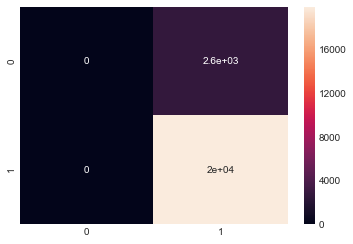

In [143]:
confusion_matrix_plot(y_test,pred)

### Summary 

### Random Forests

In [8]:
summary_of_scores_rf()

+--------------+-------------+---------------------------+-------------------+
|    Model     |  CV - Type  | Best No. of Base Learners |   Best Accuracy   |
+--------------+-------------+---------------------------+-------------------+
|     BOW      | Grid Search |             20            | 89.84228571428572 |
|   Trigram    | Grid Search |             10            | 89.18349206349207 |
|    Tf-Idf    | Grid Search |             10            |  89.4857142857143 |
|     W2V      | Grid Search |             20            | 89.91238095238096 |
| Tf-Idf - W2v | Grid Search |             60            | 88.09904761904762 |
+--------------+-------------+---------------------------+-------------------+


### Gradient Boosted Decision Trees

In [11]:
summary_of_scores_gbdt()

+--------------+-------------+---------------------------+------------+---------------+-------------------+
|    Model     |  CV - Type  | Best No. of Base Learners | Max. Depth | Learning Rate |   Best Accuracy   |
+--------------+-------------+---------------------------+------------+---------------+-------------------+
|     BOW      | Grid Search |            100            |     18     |      0.5      | 91.75111111111111 |
|   Trigram    | Grid Search |             70            |     4      |      0.7      |  91.5784126984127 |
|    Tf-Idf    | Grid Search |             70            |     9      |      0.6      | 91.86031746031746 |
|     W2V      | Grid Search |             70            |     5      |      0.2      | 90.67174603174604 |
| Tf-Idf - W2v | Grid Search |             20            |     4      |      0.1      | 88.12698412698413 |
+--------------+-------------+---------------------------+------------+---------------+-------------------+
